# Paper: Layer charges in SNO-BTO heterostructures

Notebook that generates all the figures for the paper. The functions needed to process and plot the data are in the python_function directories. 

- Part 1: all data is read in and brought into the right formatting
- Part 2: Figures in the same order as given in the paper

In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np


# PYMATGEN
from pymatgen.io.vasp.outputs import Outcar, Vasprun
from pymatgen.io.ase import AseAtomsAdaptor # convert Ase to pymatgen
from pymatgen.core import Structure, Element

# for plotting
import matplotlib.pyplot as plt # plotting
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns # different colors and add ons for plots
plt.rcParams.update({'font.size': 18})

# curve fitting
from scipy.optimize import curve_fit

# physical constants
from scipy.constants import e # elementary charge

# for saving and loading data
from bson.json_util import loads

# panda
import pandas as pd

# functions for data analysis
from python_functions.elstat_model import energy_model_depol_and_selfscreen, energy_model_depol_field, load_3d_array_from_txt, getmin 
from python_functions.dos_plots import plot_dos_per_layer, get_summed_dos_for_layer, get_bandgap
from python_functions.superlattice import get_order_per_layer
from python_functions.polarization import pol_from_layers, pol_from_layers_nt, myround, get_pol_from_charges

# definition of cm for plotting
cm = 1/2.54

!! Adjust path directories for input and output here !!

In [2]:
# write output
import os
dirname = os.getcwd()

# output directory for figures
figures_out = os.path.join(dirname, 'figures/')

# location of data
path_data = '../materials_cloud_data/'

colorpalette for figures

In [3]:
colpal = sns.color_palette(['#DDAA33', '#128869','#0056AF', '#863481', '#000000'])
sns.set_palette(colpal) # set new color palette
sns.set_style("ticks")


### Data

#### bulk structures of BaTiO3 and SmNiO3

In [4]:
# bulk structures

# --- BaTiO3 ---
# BaTiO3 strained to STO
bto_polar = Structure.from_file(path_data+'/bulk/batio3/bto_polar_strained/static/POSCAR') # polar 
bto_unpol = Structure.from_file(path_data+'/bulk/batio3/bto_unpolar_strained/static/POSCAR') # centrosymmetric

# POLARIZATION of the bulk
outcar_pol = AseAtomsAdaptor.get_atoms(bto_polar)
pos_unpol = myround(outcar_pol.get_scaled_positions())
outcar_unpol = outcar_pol.copy()
outcar_unpol.set_scaled_positions(pos_unpol)

# Formal charges
chem_symbols = np.array(outcar_pol.get_chemical_symbols())
charges = np.zeros([len(chem_symbols), 3, 3])
m_Ba = np.zeros([3, 3])
np.fill_diagonal(m_Ba, 2)
m_O = np.zeros([3, 3])
np.fill_diagonal(m_O, -2)
m_Ti = np.zeros([3, 3])
np.fill_diagonal(m_Ti, 4)

# bring into correct format     
charges[chem_symbols=='Ba'] = np.array([m_Ba for charge in charges[chem_symbols=='Ba']])
charges[chem_symbols=='Ti'] = np.array([m_Ti for charge in charges[chem_symbols=='Ti']])
charges[chem_symbols=='O'] = np.array([m_O for charge in charges[chem_symbols=='O']])

# polarization
polarisation = get_pol_from_charges(outcar_pol.get_positions(),outcar_unpol.get_positions(), charges, outcar_pol.get_volume())
print(f"P_b = {np.linalg.norm(polarisation):.2f} muC/m^2")

c_bto = bto_polar.lattice.c

# --- SmNiO3 ---
# SmNiO3 strained to STO
sno_unpol = Structure.from_file(path_data+'/bulk/smnio3/no_rots/static/POSCAR')
sno_rots = Structure.from_file(path_data+'/bulk/smnio3/with_rots/static/POSCAR')

P_b = 28.58 muC/m^2


#### Superlattice without rotations: 

##### (BaTiO3)$_5$(SmNiO3)$_4$

Data for superlattices with 5 BaTiO3 and 4 SmNiO3 layers with no rotations

In [5]:
## NOT RELAXED STRUCTURE ##

path_5_nt = path_data+'/no_rots/bto5_sno4/not_relax/dos/'
dos_5_nt = Vasprun(path_5_nt+'vasprun.xml').complete_dos.as_dict() # DOS
het_5_nt = Structure.from_file(path_5_nt+'POSCAR') # heterostructure
layer_5_nt = get_order_per_layer(het_5_nt, 5, nt=True) # Structure and atom indices per layer

## BTO RELAXATION ##

path_nt_bto = path_data+'/no_rots/bto5_sno4/bto_relax/dos/'
dos_5_nt_bto = Vasprun(f"{path_nt_bto}/vasprun.xml").complete_dos.as_dict() # DOS
het_5_nt_bto = Structure.from_file(f"{path_nt_bto}/POSCAR") # heterostructure
layer_5_nt_bto = get_order_per_layer(het_5_nt_bto, 5, nt=True) # Structure and atom indices per layer

# shift Ni to bottom of unit cell (so that all superlattices have the same order of BaTiO3 and SmNiO3 layers)
shift_Ni = 1-het_5_nt_bto.frac_coords[np.array(het_5_nt_bto.species)==Element('Ni')][0,2] # calc shift
het_5_nt_bto = het_5_nt_bto.translate_sites([i for i in range(len(het_5_nt_bto))], [0, 0, shift_Ni])

## FULL RELAXATION ##

path_nt_full = path_data+'/no_rots/bto5_sno4/full_relax/dos/'
dos_5_nt_full = Vasprun(f"{path_nt_full}/vasprun.xml").complete_dos.as_dict() # DOS
het_5_nt_full = Structure.from_file(f"{path_nt_full}/POSCAR") # heterostructure
layer_5_nt_full = get_order_per_layer(het_5_nt_full, 5, nt=True) # Structure and atom indices per layer

# shift Ni to bottom of unit cell
shift_Ni = 1-het_5_nt_full.frac_coords[np.array(het_5_nt_full.species)==Element('Ni')][0,2] # calc shift
het_5_nt_full = het_5_nt_full.translate_sites([i for i in range(len(het_5_nt_full))], [0, 0, shift_Ni])



/Users/esimmen/.pyenv/versions/3.12.2/envs/240402_atomate2/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1256: UserWarning: No POTCAR file with matching TITEL fields was found in

  if potcar := self.get_potcars(path):
/Users/esimmen/.pyenv/versions/3.12.2/envs/240402_atomate2/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1274: UserWarning: No POTCAR file with matching TITEL fields was found in

  potcar = self.get_potcars(path)


number of A: 9, number of B: 9, number of O: 27
number of layers: 9
number of A: 9, number of B: 9, number of O: 27
number of layers: 9
number of A: 9, number of B: 9, number of O: 27
number of layers: 9


In [6]:
# Calculate polarizations

# BaTiO3 relaxation only
pol_bto_relax = pol_from_layers_nt(AseAtomsAdaptor.get_atoms(het_5_nt_bto), layer_5_nt_bto)

# Full relaxation
p_full_happy = pol_from_layers_nt(AseAtomsAdaptor.get_atoms(het_5_nt_full), layer_5_nt_full)


##### (BaTiO3)5(SmNiO3)n, n=6,8

In [55]:
# read in the DOS for superlattices with 5 Batio3 and 6 or 8 SmNiO3 and disabled rotations

# 6 SmNiO3
path_6sno_nt_nr = path_data+'/no_rots/bto5_sno6/not_relax/' # path to 6 SmNiO3
dos_6sno_nt_nr = Vasprun(f"{path_6sno_nt_nr}dos/vasprun.xml").complete_dos.as_dict() # read in DOS
het_6sno_nt_nr = Structure.from_file(f"{path_6sno_nt_nr}dos/POSCAR") # read in structure
layer_6sno_nt_nr = get_order_per_layer(het_6sno_nt_nr, 5, nt=True) # get order per layer

# 8 SmNiO3
path_8sno_nt_nr = path_data+'/no_rots/bto5_sno8/not_relax/'
dos_8sno_nt_nr = Vasprun(f"{path_8sno_nt_nr}dos/vasprun.xml").complete_dos.as_dict()
het_8sno_nt_nr = Structure.from_file(f"{path_8sno_nt_nr}dos/POSCAR")
layer_8sno_nt_nr = get_order_per_layer(het_8sno_nt_nr, 5, nt=True)

/Users/esimmen/.pyenv/versions/3.12.2/envs/240402_atomate2/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1256: UserWarning: No POTCAR file with matching TITEL fields was found in

  if potcar := self.get_potcars(path):
/Users/esimmen/.pyenv/versions/3.12.2/envs/240402_atomate2/lib/python3.12/site-packages/pymatgen/io/vasp/outputs.py:1274: UserWarning: No POTCAR file with matching TITEL fields was found in

  potcar = self.get_potcars(path)


number of A: 11, number of B: 11, number of O: 33
number of layers: 11
number of A: 13, number of B: 13, number of O: 39
number of layers: 13


#### Superlattice with rotations: (BaTiO3)$_5$(SmNiO3)$_4$ 

Data for superlattices with 5 BaTiO3 and 4 SmNiO3 layers for SmNiO3 with rotations

In [7]:
################
# NOT RELAXED ##
################
path_dos_bto5_nr = path_data+'/with_rots/bto5_sno4/not_relax/dos/'
struct_5_bto_nr = Structure.from_file(path_dos_bto5_nr+'POSCAR')
layer_5_bto_nr = get_order_per_layer(struct_5_bto_nr, 10)
dos_bto5_nr = Vasprun(path_dos_bto5_nr+'vasprun.xml').complete_dos.as_dict()

struct_5_in = Structure.from_file(path_data+'/with_rots/bto5_sno4/not_relax/static/POSCAR')
layer_5_in = get_order_per_layer(struct_5_in, 10)
res_in_BTO, res_in_SNO = pol_from_layers(AseAtomsAdaptor.get_atoms(struct_5_in), layer_5_in)

####################
## BTO RELAXATION ##
####################
path = path_data+'/with_rots/bto5_sno4/bto_relax/dos/'
struct_5_bto_brel = Structure.from_file(path+'POSCAR')
layer_5_bto_brel = get_order_per_layer(struct_5_bto_brel, 10)
dos_5_bto_brel = Vasprun(path+'vasprun.xml').complete_dos.as_dict()
res_brel_BTO, res_brel_SNO = pol_from_layers(AseAtomsAdaptor.get_atoms(struct_5_bto_brel), layer_5_bto_brel)

#####################
## FULL RELAXATION ##
#####################
path = path_data+'/with_rots/bto5_sno4/full_relax/dos/'
struct_5_full_rel = Structure.from_file(path+'POSCAR')
layer_5_full_rel = get_order_per_layer(struct_5_full_rel, 10)
dos_5_full_rel = Vasprun(path+'vasprun.xml').complete_dos.as_dict()
res_full_BTO, res_full_SNO = pol_from_layers(AseAtomsAdaptor.get_atoms(struct_5_full_rel), layer_5_full_rel)

number of A: 18, number of B: 18, number of O: 54
number of layers: 9
number of A: 18, number of B: 18, number of O: 54
number of layers: 9
number of A: 18, number of B: 18, number of O: 54
number of layers: 9
number of A: 18, number of B: 18, number of O: 54
number of layers: 9


#### Critical thickness: 1-5 layers of BaTiO$_3$

Data for relaxed superlattices with 1-5 layers of BaTiO3 and 4 layers of SmNiO3 with active rotations

In [8]:
# 1 BaTiO3 layer
path_res = path_data+'/with_rots/bto1_sno4/full_relax/' # path
het_1bto = Structure.from_file(path_res+'static/POSCAR') # structure
layer_1bto = get_order_per_layer(het_1bto, 10) # id of atoms per formula unit layer
pol_1bto, _ = pol_from_layers(AseAtomsAdaptor.get_atoms(het_1bto), layer_1bto) # polarization

# 2 BaTiO3 layers
path_res = path_data+'/with_rots/bto2_sno4/full_relax/'
het_2bto = Structure.from_file(path_res+'static/POSCAR')
layer_2bto = get_order_per_layer(het_2bto, 10)
pol_2bto, _ = pol_from_layers(AseAtomsAdaptor.get_atoms(het_2bto), layer_2bto)

# 3 BaTiO3 layers
path_res = path_data+'/with_rots/bto3_sno4/full_relax/'
het_3bto = Structure.from_file(path_res+'static/POSCAR')
layer_3bto = get_order_per_layer(het_3bto, 10)
pol_3bto, _ = pol_from_layers(AseAtomsAdaptor.get_atoms(het_3bto), layer_3bto)

# 4 BaTiO3 layers
path_res = path_data+'/with_rots/bto4_sno4/full_relax/'
het_4bto = Structure.from_file(path_res+'static/POSCAR')
layer_4bto = get_order_per_layer(het_4bto, 10)
pol_4bto, _ = pol_from_layers(AseAtomsAdaptor.get_atoms(het_4bto), layer_4bto)

# 5 BaTiO3 layers
path_res = path_data+'/with_rots/bto5_sno4/full_relax/'
het_5bto = Structure.from_file(path_res+'static/POSCAR')
layer_5bto = get_order_per_layer(het_5bto, 10)
pol_5bto, _ = pol_from_layers(AseAtomsAdaptor.get_atoms(het_5bto), layer_5bto)

number of A: 10, number of B: 10, number of O: 30
number of layers: 5
number of A: 12, number of B: 12, number of O: 36
number of layers: 6
number of A: 14, number of B: 14, number of O: 42
number of layers: 7
number of A: 16, number of B: 16, number of O: 48
number of layers: 8
number of A: 18, number of B: 18, number of O: 54
number of layers: 9


#### Superlattice in the unhappy orientation 

##### Active rotations in SmNiO3: (BaTiO3)$_5$(SmNiO3)$_4$   

In [9]:
# relaxed structure with middle 3 layers of BaTiO3 fixed
dir_res = path_data+'/with_rots/bto5_sno4/unhappy/' # path
struct_5bto_uhp = Structure.from_file(f'{dir_res}static/POSCAR') # structure
layer_5bto_uhp = get_order_per_layer(struct_5bto_uhp, 10) # id of atoms per formula unit layer
dos_uhp = Vasprun(f'{dir_res}dos/vasprun.xml').complete_dos.as_dict() # DOS

number of A: 18, number of B: 18, number of O: 54
number of layers: 9


In [10]:
# Polarization
p_5bto_uh_l3, _ = pol_from_layers(AseAtomsAdaptor.get_atoms(struct_5bto_uhp), layer_5bto_uhp)

# pol_sno_l3 = p_5bto_uh_l3["pol"][:,2].copy()
# pol_sno_l3[0:2] = p_5bto_uh_l3_sno["pol"][0]
# pol_sno_l3[7:9] = p_5bto_uh_l3_sno["pol"][1]

##### Disabled rotations in SmNiO3: (BaTiO3)$_5$(SmNiO3)$_4$

In [11]:
# relaxed structure with middle 3 BaTiO3 layers fixed
dir_res = path_data+'/no_rots/bto5_sno4/unhappy/' # path
struct_5bto_nt_uhp = Structure.from_file(f'{dir_res}static/POSCAR') # structure
layer_5bto_nt_uhp = get_order_per_layer(struct_5bto_nt_uhp, 5, nt=True) # id of atoms per formula unit layer
dos_uhp_nt = Vasprun(f'{dir_res}dos/vasprun.xml').complete_dos.as_dict() # DOS

number of A: 9, number of B: 9, number of O: 27
number of layers: 9


In [12]:
# Polarization
p_5bto_uh_nt_l3 = pol_from_layers_nt(AseAtomsAdaptor.get_atoms(struct_5bto_nt_uhp), layer_5bto_nt_uhp)

#### Soft mode distortion of BaTiO3 in (BaTiO3)$_n$(SmNiO3)$_4$ ($n$ = 1,5,10)

Results for superlattices with active rotations

In [13]:
# read in energy per distortion step

# all fractional distortions
frac_displ_res = np.linspace(-1, 1.4, 13)

# number of BaTiO3 layers
btos = np.array([1,5,10])

# array to store energies
en_frac_nr = np.zeros([len(btos), len(frac_displ_res)])

# read in energies: loop over results
for j, bto in enumerate(btos):
    path_out = path_data+f'/with_rots/bto{bto}_sno4/soft_mode/' # path

    # loop over fractional displacements
    for i, frac in enumerate(frac_displ_res):
        if i == 5 & bto ==5: # format of path is different for this case
            frac = 0
            path_frac = path_out+f'frac_{frac:.2f}/'.replace('.','-')
        else:
            path_frac = path_out+f'frac_{frac:.2f}/'.replace('.','-')

        # read in energy
        outcar = Outcar(path_frac+'OUTCAR')
        en_frac_nr[j, i] = outcar.final_fr_energy

Results for superlattices with disabled distortions

In [14]:
# --- 5 & 10 BaTiO3 layers ---
# fractional displacements
frac_displ_res_5 = np.linspace(-1, 1.4, 13)

# number of BaTiO3 layers
btos = np.array([ 5, 10])

# array to store energies
en_frac_nt_nr = np.zeros([len(btos), len(frac_displ_res_5)])

# read in energies: loop over results
for j, bto in enumerate(btos):

    # path
    path_out = path_data+f'/no_rots/bto{bto}_sno4/soft_mode/'

    # loop over fractional displacements
    for i, frac in enumerate(frac_displ_res_5):
        
        path_frac = path_out+f'frac_{frac:.2f}/'.replace('.','-')

        # read in energy
        outcar = Outcar(path_frac+'OUTCAR')
        en_frac_nt_nr[j, i] = outcar.final_fr_energy

# --- 30 BaTiO3 layers ---
# fractional displacements
frac_displ_res_30 = np.linspace(-1.2, 1.4, 14)

# array to store energies
en_frac_nt_nr_30 = np.zeros(len(frac_displ_res_30))

# loop over fractional displacements
for i, frac in enumerate(frac_displ_res_30):
    path_frac = path_data+'/no_rots/bto30_sno4/soft_mode/'+f'frac_{frac:.2f}/'.replace('.','-')

    # read in energies
    outcar = Outcar(path_frac+'OUTCAR')
    en_frac_nt_nr_30[i] = outcar.final_fr_energy

#### Data and results for the electrostatic model

Functions used to fit all phonon modes

In [15]:
# Define the function to fit
def fit_4th_order_poly(P, a, b, c):
    return a * P**2 + b * P**4 + c

def fit_2nd_order_poly(P, a, b):
    return a * P**2 + b

##### Softmode in BaTiO3 bulk from polar phonon mode

In [16]:
# --- Read in data ---

# read in results from database
with open(path_data+'/bulk/batio3/phonon_calc_polar_cell.json', 'r') as file:
    result = loads(file.read())


# arrays to store results
energies_bto_nr_pcell_phonopy_eqmass = [] # energies
displacements_bto_nr_pcell_phonopy_eqmass = [] # displacements
struct_bto_phonon_eqmass = [] # structures

# loop over results
for res in result:
    energies_bto_nr_pcell_phonopy_eqmass.append(res["output"]["output"]["energy"])
    displacements_bto_nr_pcell_phonopy_eqmass.append(float(res["metadata"]["comment"].split(" ")[-1]))
    struct_bto_phonon_eqmass.append(Structure.from_dict(res["output"]["output"]["structure"]))

# numpy array
energies_bto_nr_pcell_phonopy_eqmass = np.array(energies_bto_nr_pcell_phonopy_eqmass)
displacements_bto_nr_pcell_phonopy_eqmass = np.array(displacements_bto_nr_pcell_phonopy_eqmass)

# sort data
sorted_i = np.argsort(displacements_bto_nr_pcell_phonopy_eqmass)
displacements_bto_nr_pcell_phonopy_eqmass = displacements_bto_nr_pcell_phonopy_eqmass[sorted_i]
energies_bto_nr_pcell_phonopy_eqmass = energies_bto_nr_pcell_phonopy_eqmass[sorted_i]

# displacement amplitudes
displacements_bto_nr_pcell_phonopy_eqmass = np.linspace(-1.2, 1.2,21)[0:-1]


# --- Get polarizations for every displacement ---

# list to store polarizations
pol_bto_pcell_nonrel_phonon_eqmass = []

# formal charges SmNiO3
m_O = np.zeros([3, 3])
np.fill_diagonal(m_O, -2)
m_Ti = np.zeros([3, 3])
np.fill_diagonal(m_Ti, 4)
m_Ba = np.zeros([3, 3])
np.fill_diagonal(m_Ba, 2)

# loop over structures
for i in sorted_i:
        # structure
        struct = struct_bto_phonon_eqmass[i]
        
        # order charges 
        chem_symbols = np.array([str(specie) for specie in struct.species]) 
        charges = np.zeros([len(chem_symbols), 3, 3])
        charges[chem_symbols=='Ti'] = np.array([m_Ti for charge in charges[chem_symbols=='Ti']])
        charges[chem_symbols=='Ba'] = np.array([m_Ba for charge in charges[chem_symbols=='Ba']])
        charges[chem_symbols=='O'] = np.array([m_O for charge in charges[chem_symbols=='O']])
        
        # calculate polarization
        pol = get_pol_from_charges(struct.cart_coords, np.matmul(myround(struct.frac_coords, 1, 0.5), struct.lattice.matrix), charges, struct.volume)
        pol_bto_pcell_nonrel_phonon_eqmass.append(pol)

# array in C/m^2
pol_bto_pcell_nonrel_phonon_eqmass = np.array(pol_bto_pcell_nonrel_phonon_eqmass)/100 # in C/m^2

# fit E = a*P**2 + b* P**4 to data
fit_range = abs(pol_bto_pcell_nonrel_phonon_eqmass[:,2]) < 0.3
popt, pcov = curve_fit(fit_4th_order_poly, pol_bto_pcell_nonrel_phonon_eqmass[fit_range,2], energies_bto_nr_pcell_phonopy_eqmass[fit_range])
perr = np.sqrt(np.diag(pcov))  # standard-deviation estimates for each coefficient

# popt contains the optimized values for a and b
a_opt_form_bto_pol, b_opt_form_bto_pol, c_opt_form_bto_pol = popt

print(f"Optimized parameters are a = {a_opt_form_bto_pol} pm {perr[0]} and b = {b_opt_form_bto_pol} pm {perr[1]} and c = {c_opt_form_bto_pol} pm {perr[2]}")

Optimized parameters are a = -3.2870873156048908 pm 0.02699338685945239 and b = 28.828870090007285 pm 0.3339223660026503 and c = -41.87256863280185 pm 0.00036884419439603297


##### Softmode in SmNiO3 bulk with rotations from lowest polar phonon mode

In [17]:
# --- Read in results ---

# read in results from database
with open(path_data+'/bulk/smnio3/with_rots/phonon_calc_band9.json', 'r') as file:
    result = loads(file.read())

# array to store results
energies_sno_wt = [] # energies
displacements_sno_wt = [] # displacements
structs_sno_wt = [] # structures

# loop over results
for res in result:
    energies_sno_wt.append(res["output"]["output"]["energy"])
    displacements_sno_wt.append(float(res["metadata"]["comment"].split(" ")[-1]))
    structs_sno_wt.append(Structure.from_dict(res["output"]["structure"]))

# convert to np array
energies_sno_wt = np.array(energies_sno_wt)
displacements_sno_wt = np.array(displacements_sno_wt)

# --- Get polarization for ever phonon displacement
# array for results
polarization_sno_wt = []

# formal charges SmNiO3
m_O = np.zeros([3, 3])
np.fill_diagonal(m_O, -2)
m_Ni = np.zeros([3, 3])
np.fill_diagonal(m_Ni, 3)
m_Sm = np.zeros([3, 3])
np.fill_diagonal(m_Sm, 3)

# loop over displacements
for i, displ in enumerate(displacements_sno_wt):
        
        # order charges 
        chem_symbols = np.array([str(specie) for specie in structs_sno_wt[i].species]) # species as string array
        charges = np.zeros([len(chem_symbols), 3, 3])
        charges[chem_symbols=='Ni'] = np.array([m_Ni for charge in charges[chem_symbols=='Ni']])
        charges[chem_symbols=='Sm'] = np.array([m_Sm for charge in charges[chem_symbols=='Sm']])
        charges[chem_symbols=='O'] = np.array([m_O for charge in charges[chem_symbols=='O']])
        
        # calculate polarization
        pol = get_pol_from_charges(structs_sno_wt[i].cart_coords, np.matmul(myround(structs_sno_wt[i].frac_coords, 2, 0.25), structs_sno_wt[i].lattice.matrix), charges, structs_sno_wt[i].volume)
        polarization_sno_wt.append(pol)

# convert to C/m^2
polarization_sno_wt = np.array(polarization_sno_wt)/100 # in C/m^2

# fit to data
popt, pcov = curve_fit(fit_2nd_order_poly, polarization_sno_wt[:,1], energies_sno_wt)
perr = np.sqrt(np.diag(pcov))  # standard-deviation estimates for each coefficient

# popt contains the optimized values for a and b
a_opt_form_sno_rots, b_opt_form_sno_rots = popt

print(f"Optimized parameters are a = {a_opt_form_sno_rots} pm {perr[0]} and b = {0} pm {0} and c = {b_opt_form_sno_rots} pm {perr[1]}")

Optimized parameters are a = 1034.4548063916682 pm 3.745058524932044 and b = 0 pm 0 and c = -152.1199008336491 pm 0.017899133084143773


##### Softmode in SmNiO3 bulk with disabled roations for lowest polar phonon mode

In [18]:
# --- Read in results ---
# read in the results from database
with open(path_data+'/bulk/smnio3/no_rots/phonon_calc_band5.json', 'r') as file:
    result = loads(file.read())

# plot energy vs displacement
energies_sno_nt_eqmass = [] # energies
displacements_sno_nt_eqmass = [] # displacements
structs_sno_nt_eqmass = [] # strucutres

# loop over results
for res in result:
    energies_sno_nt_eqmass.append(res["output"]["output"]["energy"])
    displacements_sno_nt_eqmass.append(float(res["metadata"]["comment"].split(" ")[-1]))
    structs_sno_nt_eqmass.append(Structure.from_dict(res["output"]["structure"]))

# convert to np array
energies_sno_nt_eqmass = np.array(energies_sno_nt_eqmass)
displacements_sno_nt_eqmass = np.array(displacements_sno_nt_eqmass)

# --- get polarization for every displacement ---

# array for polarizations
polarization_sno_nt_eqmass = []

# loop over displacements
for i, displ in enumerate(displacements_sno_nt_eqmass):
        
        # order charges 
        chem_symbols = np.array([str(specie) for specie in structs_sno_nt_eqmass[i].species]) # species as string array
        charges = np.zeros([len(chem_symbols), 3, 3])
        charges[chem_symbols=='Ni'] = np.array([m_Ni for charge in charges[chem_symbols=='Ni']])
        charges[chem_symbols=='Sm'] = np.array([m_Sm for charge in charges[chem_symbols=='Sm']])
        charges[chem_symbols=='O'] = np.array([m_O for charge in charges[chem_symbols=='O']])
        
        # calculate polarization
        pol = get_pol_from_charges(structs_sno_nt_eqmass[i].cart_coords, np.matmul(myround(structs_sno_nt_eqmass[i].frac_coords, 2, 0.5), structs_sno_nt_eqmass[i].lattice.matrix), charges, structs_sno_nt_eqmass[i].volume)
        polarization_sno_nt_eqmass.append(pol)

# convert to C/m^2
polarization_sno_nt_eqmass = np.array(polarization_sno_nt_eqmass)/100 # in C/m^2

# fit E = a*P**2 + b* P**4 to data
max_p = 0.4
fit_range = abs(polarization_sno_nt_eqmass[:,2])<=max_p
popt, pcov = curve_fit(fit_4th_order_poly, polarization_sno_nt_eqmass[fit_range,2], energies_sno_nt_eqmass[fit_range])
perr = np.sqrt(np.diag(pcov))  # standard-deviation estimates for each coefficient
# popt contains the optimized values for a and b
a_opt_form_sno_norots, b_opt_form_sno_norots, c_opt_form_sno_norots = popt

print(f"Optimized parameters are a = {a_opt_form_sno_norots} pm {perr[0]} and b = {b_opt_form_sno_norots} pm {perr[1]} and c = {c_opt_form_sno_norots} perr {perr[2]}")

Optimized parameters are a = -0.019990604210772277 pm 0.002296700816938844 and b = 3.347932143439537 pm 0.020270232554929768 and c = -37.353512277996394 perr 4.298046140776728e-05


##### Parameters for electrostatic model

In [19]:
# sample size
nsamples = 300 # number of polarization samples
ncells = 200 # number of BaTiO3 or SmNiO3 formula units
i_middle = int(nsamples/2) # index of unpolar BaTiO4

# polarization values to test
c_bto = bto_polar.lattice.c # length of one unit cell
p_btos = np.linspace(-0.5, 0.5, nsamples) # polarization values of BaTiO3
p_snos = np.linspace(-0.49, 0.49, nsamples) # polar displacements of SmNiO3 no rotations
p_snos_tilted = np.linspace(-0.1, 0.1, nsamples) # polar displacements of SmNiO3 with rotations
i_uhp = p_btos < 0 # indices where superlattice is unhappy

# array for thickness
dvec = np.arange(1, ncells+1, 1)*c_bto*10**-10 # thickness of batio3
d_vec_sno_nt = np.arange(1, ncells+1, 1)*sno_unpol.lattice.c*10**-10 # thickness of smnio3 without rots
d_vec_sno_wt = np.arange(1, ncells+1, 1)*sno_rots.lattice.c*10**-10/2 # thickness of smnio3 with rots
c_vec = np.arange(1, ncells+1, 1) # thickness in formula units
d_sno = -1 # equal number of batio3 and smnio3 unit cells

# parameters

# normalize to volume and change units to eV m^4 C^-2 for a and eV m^8 C^-4 for b
# batio3
a_bto = a_opt_form_bto_pol/bto_polar.volume * 1e10**3
b_bto = b_opt_form_bto_pol/bto_polar.volume * 1e10**3
# smnior with rotations
a_sno = a_opt_form_sno_rots/sno_rots.volume * 1e10**3
b_sno = b_opt_form_sno_rots/sno_rots.volume * 1e10**3
# smnio3 without rotations
a_sno_snt = a_opt_form_sno_norots/sno_unpol.volume/(10**(-10))**3
b_sno_snt = b_opt_form_sno_norots/sno_unpol.volume/(10**(-10))**3

# lambda
factor = 1e-19 # lambda^2/epsr
eps_r = 60 # eps_r of choice
lambda_dep = np.sqrt(eps_r*factor) # corresponding lambda
eg = 3.2 # band gap

### Figure 2: Results for superlattice (BaTiO3)5(SmNiO3)4 without rotation 

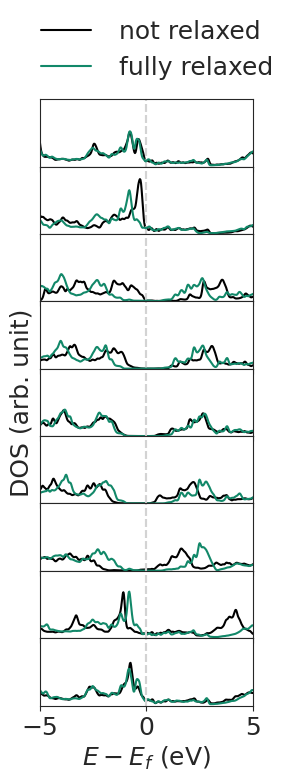

In [53]:
nlayers = len(layer_5_nt)

# plot setup
fig, ax = plt.subplots(nrows = nlayers, sharex = True, subplot_kw={'aspect': 'auto'})
fig.subplots_adjust(hspace=0)
fig.set_size_inches([7*cm, 20*cm])

# plot
fig, ax = plot_dos_per_layer([fig,ax], [dos_5_nt], ['not relaxed'], layer_5_nt, sigma=0.05, colors=[colpal[-1]])
fig, ax = plot_dos_per_layer([fig,ax], [dos_5_nt_full], ['fully relaxed'], layer_5_nt_full, sigma=0.05, colors=[colpal[1]])

# get legend
lgd = fig.legends[0]

# save
plt.savefig(f'{figures_out}fig2_dos_nt.png', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent = True)
plt.savefig(f'{figures_out}fig2_dos_nt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent = True)
plt.show()

Get band gap for every layer in the superlattice

In [54]:
nlayers = len(layer_5_nt_full)

cutoff = 0.1 # cutoff for number of states

# arrays to store results 
egap_nr_nt = np.zeros(nlayers)
egap_fr_nt = np.zeros(nlayers)

# loop over layers
for i in (range(nlayers)):
    # band gap not relaxed
    dos_layer_i = get_summed_dos_for_layer(dos_5_nt, layer_5_nt[i], sigma=0.05)
    egap_nr_nt[i], lower_edge, upper_edge = get_bandgap(dos_layer_i, np.array(dos_5_nt['energies'])-dos_5_nt['efermi'], cutoff=cutoff)

    # band gap relaxed
    dos_layer_i = get_summed_dos_for_layer(dos_5_nt_full, layer_5_nt_full[i], sigma=0.05)
    egap_fr_nt[i], lower_edge, upper_edge = get_bandgap(dos_layer_i, np.array(dos_5_nt_full['energies'])-dos_5_nt['efermi'], cutoff=cutoff)

band_gaps = pd.DataFrame({'not relaxed': egap_nr_nt, 'fully relaxed': egap_fr_nt})
print(band_gaps)

## print band gaps and average band gap

print(f'Band gaps for not relaxed: {egap_nr_nt[2:7]},average no interface: {np.mean(egap_nr_nt[3:6]):.1f}')
print(f'Band gaps for fully relaxed: {egap_fr_nt[2:7]}, average no interface: {np.mean(egap_fr_nt[3:6]):.1f}')


   not relaxed  fully relaxed
0       0.0000         0.0000
1       0.0000         0.0000
2       1.3454         1.0881
3       1.5524         1.8395
4       1.3455         1.8136
5       1.2937         1.7877
6       1.0091         0.8809
7       0.0000         0.0000
8       0.0000         0.0000
Band gaps for not relaxed: [1.3454 1.5524 1.3455 1.2937 1.0091],average no interface: 1.4
Band gaps for fully relaxed: [1.0881 1.8395 1.8136 1.7877 0.8809], average no interface: 1.8


Local polarization in superlattice, BaTiO3 and full relaxations

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/3289014539.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)")


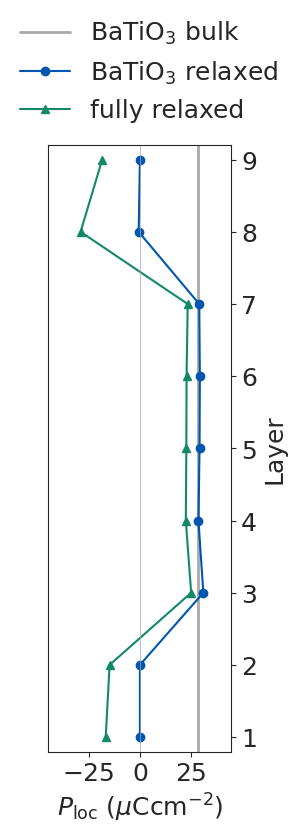

In [55]:
# set up figure
fig, ax= plt.subplots(subplot_kw={'aspect': 'auto'})
fig.subplots_adjust(hspace=0)
fig.set_size_inches([6*cm, 20*cm])

# bulk polarization
p_bulk = np.zeros(9)
p_bulk[2:7] = 28.6
plt.axvline(28.6, color = 'darkgray', ls = '-', lw = 2, label = 'BaTiO$_3$ bulk')

# plot polarization along z
i_ax = 2
plt.plot(pol_bto_relax["pol."][:,i_ax],  np.arange(1, 10, 1), 'o-', label = 'BaTiO$_3$ relaxed', color = colpal[2])
plt.plot(p_full_happy["pol."][:,i_ax], np.arange(1, 10, 1), '^-',label = 'fully relaxed', color = colpal[1])

# labels 
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
lgd = plt.legend(loc = 'lower center', bbox_to_anchor = [0.55, 1.00], frameon=False, bbox_transform=ax.transAxes)
plt.ylabel("Layer")
plt.xlabel("$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)")

# limits and line at zero
plt.axvline(0, color = 'darkgray', ls = '-', lw = 0.5)
plt.xlim([-45, 45])
plt.ylim([0.8, 9.2])

plt.savefig(f'{figures_out}fig2_pol_hp_nt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent = True)
plt.show()

### Figure 3: Band bending of core states in BaTiO3

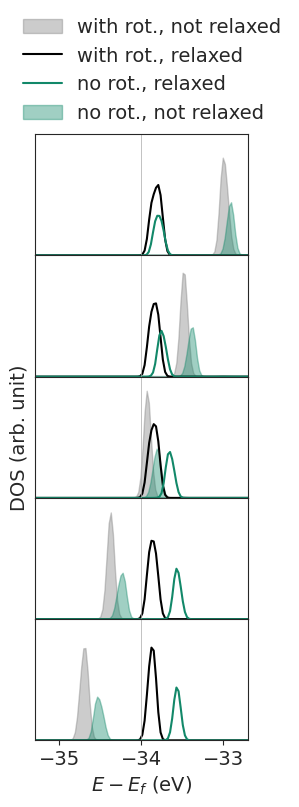

In [59]:
nlayers = len(layer_5bto_uhp)

# set up figure
fig, ax = plt.subplots(nrows = nlayers-4, sharex = True, subplot_kw={'aspect': 'auto'})
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'DejaVu Sans'
fig.subplots_adjust(hspace=0)
fig.set_size_inches([7*cm, 20*cm])

# values in between x limit
xlims =[-36,-32]

# array for results
max_vals = np.zeros([8, 5])

# loop over layers
for i in (range(nlayers)):
    
    # only in BaTiO3 layers
    if i <2 or i > 6:
        continue

    # --- results with rotations ---

    # 1) No relaxation
    # dos for the layer
    dos_layer_i = get_summed_dos_for_layer(dos_bto5_nr, layer_5_bto_nr[i], sigma=0.03)
    energies = np.array(dos_bto5_nr['energies'])-dos_bto5_nr['efermi']

    # find maximum of peak
    indices = np.logical_and((energies>xlims[0]), (energies<xlims[1]))
    max_vals[0,nlayers-2-1-i] = energies[indices][np.argmax(dos_layer_i[indices])]

    # plot
    wt_nr = ax[nlayers-2-1-i].fill_between(energies, dos_layer_i, alpha=0.4, color = 'gray')
    
    
    # 2) Full relaxation
    dos_layer_i = get_summed_dos_for_layer(dos_5_full_rel, layer_5_full_rel[i], sigma=0.03)
    energies = np.array(dos_5_full_rel['energies'])-dos_5_full_rel['efermi']
    indices = np.logical_and((energies>xlims[0]), (energies<xlims[1]))
    max_vals[1,nlayers-2-1-i] = energies[indices][np.argmax(dos_layer_i[indices])]
    wt_r = ax[nlayers-2-1-i].plot(energies, dos_layer_i, color = 'black')
    

    
    # --- results without rotations
    # 1) No relaxation
    dos_layer_i = get_summed_dos_for_layer(dos_5_nt, layer_5_nt[i], sigma=0.03)
    energies = np.array(dos_5_nt['energies'])-dos_5_nt['efermi']
    indices = np.logical_and((energies>xlims[0]), (energies<xlims[1]))
    max_vals[2,nlayers-2-1-i] = energies[indices][np.argmax(dos_layer_i[indices])]
    nt_nr = ax[nlayers-2-1-i].fill_between(energies, dos_layer_i, alpha=0.4, color = colpal[1])

    # 2) Full relaxation
    dos_layer_i = get_summed_dos_for_layer(dos_5_nt_full, layer_5_nt_full[i], sigma=0.03)
    energies = np.array(dos_5_nt_full['energies'])-dos_5_nt_full['efermi']
    indices = np.logical_and((energies>xlims[0]), (energies<xlims[1]))
    max_vals[3,nlayers-2-1-i] = energies[indices][np.argmax(dos_layer_i[indices])]
    nt_r = ax[nlayers-2-1-i].plot(energies, dos_layer_i, color = colpal[1])


    # limits    
    ax[nlayers-2-1-i].axvline(-34, color = 'darkgray', linestyle='-', linewidth = 0.5)
    ax[nlayers-2-1-i].set_xlim([-35.3,-32.7])
    ax[nlayers-2-1-i].set_ylim([0,120])
    ax[nlayers-2-1-i].yaxis.set_tick_params(labelleft=False)
    
    # remove ticks
    if i < nlayers-2:
        ax[i-2].set_yticks([])

# legend
lgd = fig.legend([wt_nr, wt_r[0], nt_r[0], nt_nr], ['with rot., not relaxed', 'with rot., relaxed', 'no rot., relaxed', 'no rot., not relaxed'], loc = 'lower center', bbox_to_anchor = [0.55, 0.95], frameon=False, bbox_transform=ax[0].transAxes) # , bbox_transform=fig.transFigure

#label
ax[-1].set_xlabel('$E-E_f$ (eV)')
ax[-1].set_xlabel('$E-E_f$ (eV)')
ax[2].set_ylabel('DOS (arb. unit)')

# plot
plt.savefig(f'{figures_out}fig3_band_bending_core_states.pdf', bbox_inches='tight', transparent=True)
plt.show()

### Figure 4: Results for superlattice (BaTiO3)5(SmNiO3)4 with active rotations 

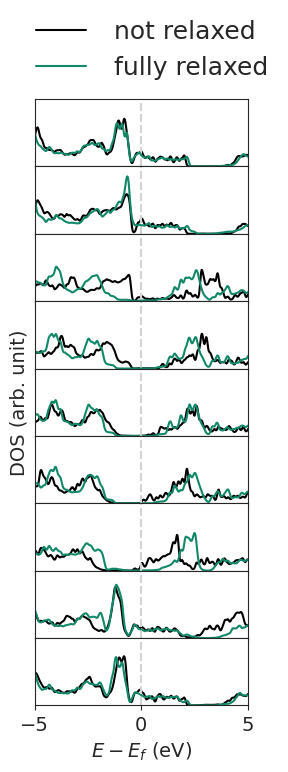

In [27]:
fig, ax = plt.subplots(nrows = nlayers, sharex = True, subplot_kw={'aspect': 'auto'})

fig.subplots_adjust(hspace=0)
fig.set_size_inches([7*cm, 20*cm])

fig, ax = plot_dos_per_layer([fig,ax], [dos_bto5_nr], ['not relaxed'], layer_5_bto_nr, sigma=0.05, colors=[colpal[-1]])
fig, ax = plot_dos_per_layer([fig,ax], [dos_5_full_rel], ['fully relaxed'], layer_5_full_rel, sigma=0.05, colors=[colpal[1]], ylim=[0,22])

lgd = fig.legends[0]

plt.savefig(f'{figures_out}fig4_dos_hp_wt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent = True)
plt.show()

Calculate band gap of BaTiO3 in the superlattice

In [60]:
# band gaps
egap_wt_nr = np.zeros(nlayers)
egap_wt_fr = np.zeros(nlayers)
cutoff = 0.1 # cutoff for number of states (below = no states)

# loop over layers
for i in (range(nlayers)):
    # not relaxed
    dos_layer_i = get_summed_dos_for_layer(dos_bto5_nr, layer_5_bto_nr[i], sigma=0.05) 
    egap_wt_nr[i], lower_edge, upper_edge = get_bandgap(dos_layer_i, np.array(dos_bto5_nr['energies'])-dos_bto5_nr['efermi'], cutoff=cutoff)

    # relaxed
    dos_layer_i = get_summed_dos_for_layer(dos_5_full_rel, layer_5_full_rel[i], sigma=0.05)
    egap_wt_fr[i], lower_edge, upper_edge = get_bandgap(dos_layer_i, np.array(dos_5_full_rel['energies'])-dos_5_full_rel['efermi'], cutoff=cutoff)

band_gaps = pd.DataFrame({'not relaxed': egap_wt_nr, 'fully relaxed': egap_wt_fr})
print(band_gaps)

## print band gaps and average band gap

print(f'Band gaps for not relaxed: {egap_wt_nr[2:7]},average no interface: {np.mean(egap_wt_nr[3:6]):.1f}')

print(f'Band gaps for fully relaxed: {egap_wt_fr[2:7]}, average no interface: {np.mean(egap_wt_fr[3:6]):.1f}')

   not relaxed  fully relaxed
0       0.3087         0.1389
1       0.0000         0.0000
2       1.1831         1.0000
3       1.1317         1.7777
4       0.8487         1.7500
5       1.0803         1.7222
6       0.0000         0.0000
7       0.3087         0.0000
8       0.2829         0.1111
Band gaps for not relaxed: [1.1831 1.1317 0.8487 1.0803 0.    ],average no interface: 1.0
Band gaps for fully relaxed: [1.     1.7777 1.75   1.7222 0.    ], average no interface: 1.7


<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/681173043.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)')


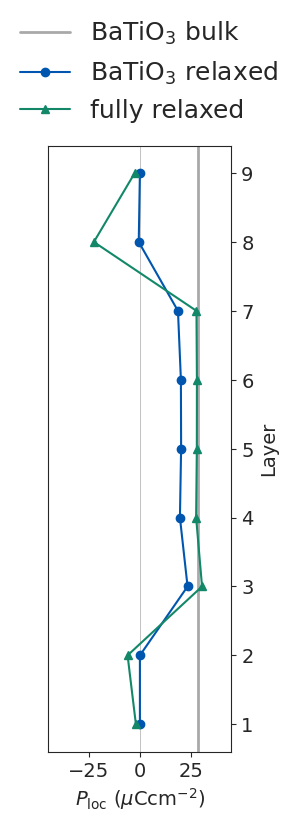

In [61]:
# batio3 bulk reference
pol_bulk = np.zeros([9, 3])
pol_bulk[2:7, 2] = 28.6

# plot setup
fig, ax = plt.subplots(1, 1)
fig.set_size_inches([6*cm, 20*cm])
plt.rcParams.update({'font.size': 18})
plt.axvline(28.6, color = 'darkgray', ls = '-', lw = 2, label = 'BaTiO$_3$ bulk')
plt.axvline(0, color = 'darkgray', ls = '-', lw = 0.5)

# plot polarization
ax.plot(res_brel_BTO["pol"][:,2,2], res_brel_BTO["name"]+1,'-o', label='BaTiO$_3$ relaxed', color = colpal[2])
ax.plot(res_full_BTO["pol"][:,2,2], res_full_BTO["name"]+1,'-^', label='fully relaxed', color = colpal[1])

# label and limits
ax.set_xlabel('$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)')
ax.set_ylabel('Layer')
ax.set_xlim([-45, 45])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# legend
lgd = plt.legend(loc = 'lower center', bbox_to_anchor = [0.55, 1.00], frameon=False, bbox_transform=ax.transAxes)

# save figure
plt.savefig(f'{figures_out}fig4_pol_hp_wt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)
plt.show()

### Figure 5: Soft mode distortion of DFT and electrostatic model

In [62]:
# Load results from electrostatic model from text files (see elstat_model_best_parameters.ipynb to soo how the values were generated) 

# load energy landscape
energies_hp_dep_wt = load_3d_array_from_txt(f'{path_data}/elstat_model/opt_energy_landscape_depANDsc_wt_factor={factor:.2E}_eg={eg}.txt')
energies_hp_dep_nt = load_3d_array_from_txt(f'{path_data}/elstat_model/opt_energy_landscape_depANDsc_nt_factor={factor:.2E}_eg={eg}.txt')
double_well_hp_dep_wt = load_3d_array_from_txt(f'{path_data}/elstat_model/opt_energy_double_well_depANDsc_wt_factor={factor:.2E}_eg={eg}.txt')
double_well_hp_dep_nt = load_3d_array_from_txt(f'{path_data}/elstat_model/opt_energy_double_well_depANDsc_nt_factor={factor:.2E}_eg={eg}.txt')

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:73: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:73: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/2800392580.py:21: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('$P_{\mathrm{BTO}}$ ($\mu C$ cm$^{-2}$)')
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/2800392580.py:73: SyntaxWarning: invalid escape sequence '\m'
  ax[0].legend(handles_1, labels_1, title = '$n_\mathrm{BTO}$', loc = 'center left', bbox_to_anchor = [1.02, 0.5], frameon=False)


--------------- 
DFT results
Delta_E for 1 u.c.: 167.09 meV/f.u.
Delta_E for 5 u.c.: 145.13 meV/f.u.
Delta_E for 10 u.c.: 99.79 meV/f.u.
---------------- 
Electrostatic model
Delta_E for 5 u.c.: 125.62 meV/f.u.
Delta_E for 10 u.c.: 71.55 meV/f.u.
Delta_E for 30 u.c.: 13.52 meV/f.u.
Delta_E for 100 u.c.: 1.23 meV/f.u.


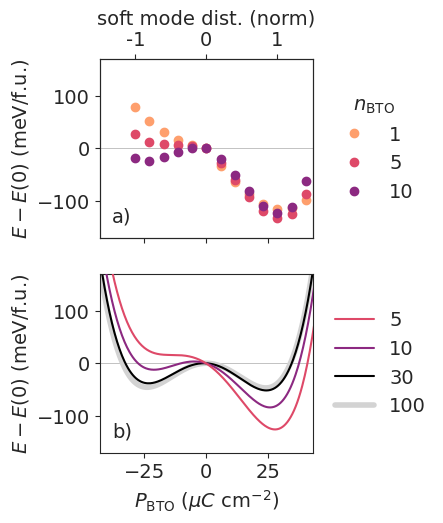

In [63]:
# fractional coordinates $ thickness
frac_displ_res = np.linspace(-1, 1.4, 13)
thicknesses = [4,9, 29, 99]

# plot parameters and color
plt.rcParams.update({'font.size': 14})
colors = plt.cm.magma_r(np.linspace(0.2,1,len(thicknesses)+1)) # get color map
# replace last color with black
colors[-2] = [0, 0, 0, 1]
symbols = ['o', '^', 's']

# set up plot
fig, ax = plt.subplots(nrows = 2, figsize=(7*cm, 13*cm), sharex = True)

# limits, label and line at zero
for a in ax:
    a.axhline(0, color = 'darkgray', ls = '-', zorder = 0, linewidth = 0.5)
    a.set_xlim([-43, 43])
    a.set_ylim([-170, 170])
    a.set_ylabel('$E-E(0)$ (meV/f.u.)')
ax[1].set_xlabel('$P_{\mathrm{BTO}}$ ($\mu C$ cm$^{-2}$)')

# batio3 thicknesses of interest
btos = np.array([1,5,10]) # bto thickness of interest


# DFT results
print('--------------- \nDFT results')
for i, bto in enumerate(btos):

    # plot energy w.r. to centrosymmetric batio3
    ax[0].plot(frac_displ_res*28.6,1000*(en_frac_nr[i]-en_frac_nr[i,5])/(2*(4+bto)), symbols[0], label = f'{bto}', color = colors[i])
    
    # print energy difference between happy and unhappy orientation
    print(f'Delta_E for {bto} u.c.: {1000*(en_frac_nr[i, 1]-en_frac_nr[i,10])/(2*(4+bto)):.2f} meV/f.u.') 

# Electrostatic model
print('---------------- \nElectrostatic model')
for i, thickness in enumerate(thicknesses):

    # change to mev/f.u. and set centrosymmetric batio3 to zero
    energies_wt_i = (energies_hp_dep_wt[thickness,:,149]-energies_hp_dep_wt[thickness,149,149])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*c_vec[thickness])*1000
    energies_nt_i = (energies_hp_dep_nt[thickness,:,149]-energies_hp_dep_nt[thickness,149,149])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*c_vec[thickness])*1000 

    zorder = [4, 3, 2] # thinnest batio3 on top
    if i == len(thicknesses)-1: # different color for thickest slab
        ax[1].plot(p_btos*100, energies_wt_i, '-',   color='lightgray', linewidth = 4,  label = f'{thickness+1}', zorder = 1)
    else:
        ax[1].plot(p_btos*100, energies_wt_i, '-',  color=colors[i+1], label = f'{thickness+1}', zorder = zorder[i])

    # difference in the two energy minima
    print(f'Delta_E for {thickness+1} u.c.: {np.min(energies_wt_i[p_btos < 0])-np.min(energies_wt_i[p_btos > 0]):.2f} meV/f.u.')  


## second axis ##
# Add a secondary x-axis on top of the first subplot
ax2_top = ax[0].twiny()  # This creates a new x-axis that shares the y-axis with ax[0]

# Determine the range of the original x-axis
original_xlim = ax[0].get_xlim()
ax2_top.set_xticks([-28.6, 0, 28.6])
ax2_top.set_xlim(original_xlim)
ax2_top.set_xlabel('soft mode dist. (norm)')

# Label these ticks as -1, 0, and 1
ax2_top.set_xticklabels(['-1', '0', '1'])

### LEGEND ###
handles_1, labels_1 = ax[0].get_legend_handles_labels()
handles_2, labels_2 = ax[1].get_legend_handles_labels()

# Create custom lines
ax[0].legend(handles_1, labels_1, title = '$n_\mathrm{BTO}$', loc = 'center left', bbox_to_anchor = [1.02, 0.5], frameon=False)
ax[1].legend(handles_2, labels_2, loc = 'center left', bbox_to_anchor = [1.02, 0.5], frameon=False)

# add letter a) b) to plot
letter = ['a', 'b']
for i, a in enumerate(ax):
    t = a.text(-38, a.get_ylim()[0]+30, f'{letter[i]})')
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

# save
plt.savefig(f'{figures_out}fig5_softmode_dft_vs_elstat.pdf', bbox_inches='tight', transparent=True)
plt.show()

### Figure 6: Critical thickness of spontaneous polarization in BaTiO3

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/2026867901.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$P_\mathrm{loc}$ ($\mu$C cm$^{-2}$)')
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/2026867901.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('slab thickness ($n_\mathrm{BTO}$)')


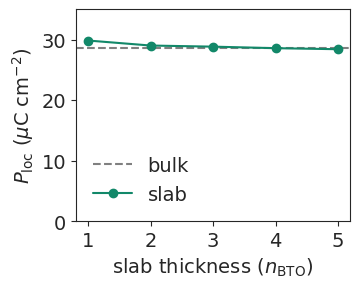

In [64]:
# plot parameters
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(9*cm, 7*cm))

# bulk reference
plt.axhline(28.6, ls='--', color='gray', label = 'bulk')

# plot polarization 
plt.plot([1,2, 3,4,5], [pol_1bto['pol'][2,2,2], np.mean(pol_2bto['pol'][2:4,2,2]), np.mean(pol_3bto['pol'][2:5,2,2]), np.mean(pol_4bto['pol'][2:6,2,2]), np.mean(pol_5bto['pol'][2:7,2,2])], 'o-', label = 'slab', color = colpal[1])

# legend and labels
lgd = plt.legend(frameon=False)
plt.ylabel('$P_\mathrm{loc}$ ($\mu$C cm$^{-2}$)')
plt.xlabel('slab thickness ($n_\mathrm{BTO}$)')

# ticks and ylim
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim([0, 35])

# save
plt.savefig(f'{figures_out}fig6_crit_thickness_bto.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)
plt.show()

### Figure 7: Results for unhappy (BaTiO3)5(SmNiO3)4 with active rotations (3 layers fixed in BaTiO3) 

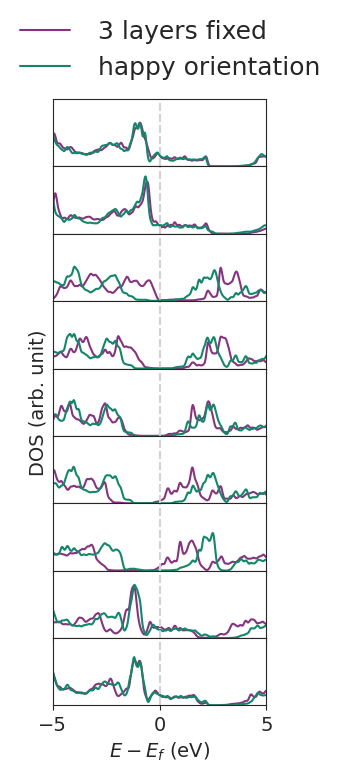

In [65]:
nlayers = len(layer_5bto_uhp)

# plot parameters
fig, ax = plt.subplots(nrows = nlayers, sharex = True, subplot_kw={'aspect': 'auto'})
fig.subplots_adjust(hspace=0)
fig.set_size_inches([7*cm, 20*cm])
plt.rcParams.update({'font.size': 18})

# plot
fig, ax = plot_dos_per_layer([fig,ax], [dos_uhp], ['3 layers fixed'], layer_5bto_uhp, sigma=0.05, colors=[colpal[3]])
fig, ax = plot_dos_per_layer([fig,ax], [dos_5_full_rel], ['happy orientation'], layer_5_full_rel, sigma=0.05, colors=[colpal[1]], ylim=[0,22])

# get legend
lgd = fig.legends[0]

plt.savefig(f'{figures_out}fig7_dos_uhp_wt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)

Get band gap for every layer in the superlattice

In [67]:
# band gaps
egap_uhp_wt = np.zeros(nlayers)
egap_hp_wt = np.zeros(nlayers)

# loop over layers
for i in (range(nlayers)):
    # unhappy orientation
    dos_layer_i = get_summed_dos_for_layer(dos_uhp, layer_5bto_uhp[i], sigma=0.05)
    egap_uhp_wt[i], lower_edge, upper_edge = get_bandgap(dos_layer_i, np.array(dos_uhp['energies'])-dos_uhp['efermi'], cutoff=cutoff)

    # full happy relaxation
    dos_layer_i = get_summed_dos_for_layer(dos_5_full_rel, layer_5_full_rel[i], sigma=0.05)
    egap_hp_wt[i], lower_edge, upper_edge = get_bandgap(dos_layer_i, np.array(dos_5_full_rel['energies'])-dos_5_full_rel['efermi'], cutoff=cutoff)

band_gaps = pd.DataFrame({'3 layers fixed': egap_uhp_wt, 'happy orientation': egap_hp_wt})
print(band_gaps)

## print band gaps and average band gap

print(f'Band gaps for 3 layers fixed: {egap_uhp_wt[2:7]},average no interface: {np.mean(egap_uhp_wt[3:6]):.1f}')

print(f'Band gaps for happy orientation: {egap_hp_wt[2:7]}, average no interface: {np.mean(egap_hp_wt[3:6]):.1f}')

   3 layers fixed  happy orientation
0          0.1540             0.1389
1          0.3336             0.0000
2          1.7448             1.0000
3          1.3599             1.7777
4          1.2316             1.7500
5          1.3855             1.7222
6          0.0000             0.0000
7          0.0000             0.0000
8          0.1027             0.1111
Band gaps for 3 layers fixed: [1.7448 1.3599 1.2316 1.3855 0.    ],average no interface: 1.3
Band gaps for happy orientation: [1.     1.7777 1.75   1.7222 0.    ], average no interface: 1.7


Polarization of relaxed structure

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/3206375850.py:16: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)')


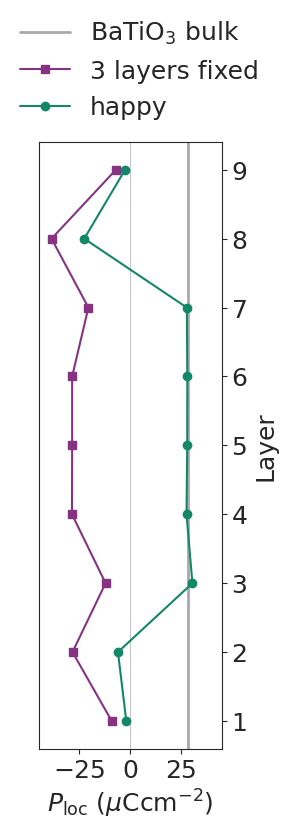

In [68]:
# plot setup
fig, ax = plt.subplots(1, 1)
fig.set_size_inches([6*cm, 20*cm])
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.axvline(0, color = 'darkgray', ls = '-', lw = 0.5)

# bulk reference
plt.axvline(28.6, color = 'darkgray', ls = '-', lw = 2, label = 'BaTiO$_3$ bulk')

# plot data
plt.plot(p_5bto_uh_l3["pol"][:,2,2], p_5bto_uh_l3["name"]+1, '-s', color = colpal[3], label = '3 layers fixed')
plt.plot(res_full_BTO["pol"][:,2,2], p_5bto_uh_l3["name"]+1, '-o', color = colpal[1], label='happy')

# label and xlimit
plt.xlabel('$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)')
plt.xlim([-45, 45]) 
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.ylabel('Layer')

# legend
lgd = plt.legend(loc = 'lower center', bbox_to_anchor = [0.55, 1.00], frameon=False, bbox_transform=ax.transAxes)

# save
plt.savefig(f'{figures_out}fig7_pol_uhp_wt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent = True)
plt.show()

### Figure 8: Energy for soft mode distortion from polar phonon modes

<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/2229216162.py:44: SyntaxWarning: invalid escape sequence '\m'
  ax[0].set_xlabel("Polarization ($\mu$C cm$^{-2}$)")
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/2229216162.py:45: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel("Polar displ. ($\mu$C cm$^{-2}$)")


P at minimum energy: -23.90


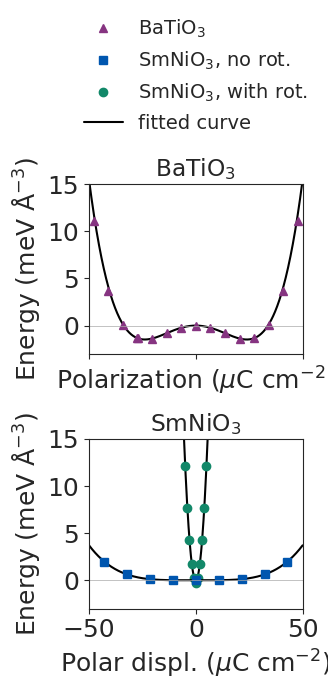

In [ ]:
# plot setup
fig, ax = plt.subplots(nrows=2, ncols=1, subplot_kw={'aspect': 'auto'}, sharex=True, figsize=(7*cm, 14*cm))
plt.rcParams.update({'font.size': 14})
# Set the font to DejaVu Sans
plt.rcParams['font.family'] = 'DejaVu Sans'

# BaTiO3 bulk
# plot fit
x_new = np.arange(-0.7, 0.7, 0.001)
ax[0].plot(x_new*100, (fit_4th_order_poly(x_new, a_opt_form_bto_pol, b_opt_form_bto_pol, c_opt_form_bto_pol)-c_opt_form_bto_pol)/bto_polar.volume*1000, '-', color='black')

# plot energy vs polarization
ax[0].plot(pol_bto_pcell_nonrel_phonon_eqmass[:,2]*100, (energies_bto_nr_pcell_phonopy_eqmass-c_opt_form_bto_pol)/bto_polar.volume*1000, '^', color=colpal[3])

# SmNiO3 bulk with rotations
# plot fit
x_new = np.arange(-0.3, 0.3, 0.001)
ax[1].plot(x_new*100, (fit_2nd_order_poly(x_new, a_opt_form_sno_rots, b_opt_form_sno_rots)-b_opt_form_sno_rots)/structs_sno_wt[-1].volume*1000, '-', color='black')
ax[1].plot(polarization_sno_wt[:,1]*100, (energies_sno_wt-b_opt_form_sno_rots)/structs_sno_wt[-1].volume*1000, 'o', color=colpal[1])

# SmNiO3 bulk without rotations
x_new = np.arange(-0.7, 0.7, 0.001)
ax[1].plot(x_new*100, (fit_4th_order_poly(x_new, a_opt_form_sno_norots, b_opt_form_sno_norots, c_opt_form_sno_norots)-c_opt_form_sno_norots)/structs_sno_nt_eqmass[-1].volume*1000, '-', color='black')

# plot energy vs polarization
ax[1].plot(polarization_sno_nt_eqmass[:,2]*100, (energies_sno_nt_eqmass-c_opt_form_sno_norots)/structs_sno_nt_eqmass[-1].volume*1000, 's', color=colpal[2])

# print P at minimum energy
print(f'P at minimum energy: {x_new[np.argmin(fit_4th_order_poly(x_new, a_opt_form_bto_pol, b_opt_form_bto_pol, c_opt_form_bto_pol))]*1e2:.2f}')

# labels
ax[0].set_ylabel("Energy (meV Å$^{-3}$)")
ax[1].set_ylabel("Energy (meV Å$^{-3}$)")

ax[0].set_title("BaTiO$_3$")
ax[1].set_title("SmNiO$_3$")

ax[0].set_xlabel("Polarization ($\mu$C cm$^{-2}$)")
ax[1].set_xlabel("Polar displ. ($\mu$C cm$^{-2}$)")

# limits
for a in ax:
    a.axhline(0, color='darkgray', ls='-', lw=0.5)
    a.set_ylim([-3, 15])
    a.set_xlim([-50, 50])

plt.subplots_adjust(hspace=0.5)  # adjust space between the subplots

# make legend for square, circle, triangle and one black line and the gray box
line_triangle = mlines.Line2D([], [], color=colpal[3], marker='^', linestyle='None', label='BaTiO$_3$')
line_square = mlines.Line2D([], [], color=colpal[2], marker='s', linestyle='None', label='SmNiO$_3$, no rot.')
line_circle = mlines.Line2D([], [], color=colpal[1], marker='o', linestyle='None', label='SmNiO$_3$, with rot.')

line_black = mlines.Line2D([], [], color='black', label='fitted curve')
patch_gray = mpatches.Patch(color='grey', alpha=0.2, label='fit range, no rotations')

# Add all lines to the legend
ax[0].legend(handles=[line_triangle, line_square, line_circle, line_black], loc='lower center', bbox_to_anchor=[.5, 1.2], frameon=False)

# save
plt.savefig(f'{figures_out}fig8_softmode_phonon_fit.pdf', bbox_inches='tight', transparent=True)

plt.show()

### Figure 9: Polarization from electrostatic model for thick slabs 

SNO wt polar displacements: hp = -0.57, uhp = -0.57
SNO nt polar displacements: hp = init. -24.42 fin.-6.06, uhp = init. -30.97 and fin. -7.05
BTO wt polar displacements: hp = 36.29, uhp = -20.23
BTO nt polar displacements: hp = 25.25, uhp = -20.23


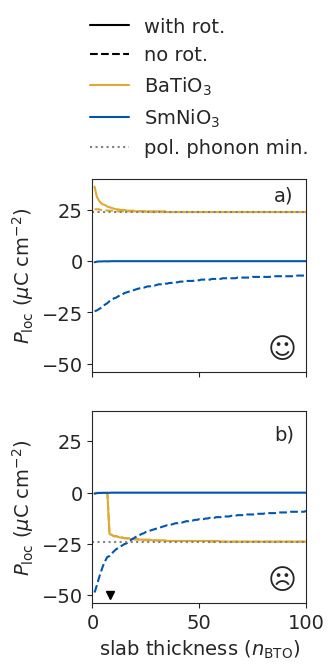

In [71]:
# plot polarization for miminum energy happy and unhappy orientation in comparison 

save_data_path = path_data+'/elstat_model/'

# parameters for electrostatic model
factor = 1e-19
eg = 3.2

# plot parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams.update({'font.size': 14})

# colors
color_i = 0
color_2 = 2

# read in data
results_hp_dep_wt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_hp_dep_wt_factor={factor:.2E}_eg={eg}.txt')
results_hp_dep_nt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_hp_dep_nt_factor={factor:.2E}_eg={eg}.txt')
results_uhp_dep_wt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_uhp_dep_wt_factor={factor:.2E}_eg={eg}.txt')
results_uhp_dep_nt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_uhp_dep_nt_factor={factor:.2E}_eg={eg}.txt')

# set up plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7*cm, 14*cm), sharex=True)

# plot happy results batio3 
ax[0].plot(c_vec, 100*results_hp_dep_wt[:,0], '-', color = colpal[color_i])
ax[0].plot(c_vec, 100*results_hp_dep_nt[:,0], '--', color = colpal[color_i])

# plot happy results smnio3
ax[0].plot(c_vec, 100*results_hp_dep_wt[:,1], '-', color = colpal[color_2])
ax[0].plot(c_vec, 100*results_hp_dep_nt[:,1], '--', color = colpal[color_2])

# print initial and final polarization
print(f'SNO wt polar displacements: hp = {results_hp_dep_wt[0,1]*100:.2f}, uhp = {results_uhp_dep_wt[0,1]*100:.2f}')
print(f'SNO nt polar displacements: hp = init. {results_hp_dep_nt[0,1]*100:.2f} fin.{results_hp_dep_nt[-1,1]*100:.2f}, uhp = init. {results_uhp_dep_nt[abs(results_uhp_dep_nt[:,0])>0.1][0,1]*100:.2f} and fin. {results_uhp_dep_nt[abs(results_uhp_dep_nt[:,0])>0.1][-1,1]*100:.2f}')
print(f'BTO wt polar displacements: hp = {results_hp_dep_wt[0,0]*100:.2f}, uhp = {results_uhp_dep_wt[abs(results_uhp_dep_wt[:,0])>0.1][0,0]*100:.2f}')
print(f'BTO nt polar displacements: hp = {results_hp_dep_nt[0,0]*100:.2f}, uhp = {results_uhp_dep_nt[abs(results_uhp_dep_nt[:,0])>0.1][0,0]*100:.2f}')


# plot unhappy results batio3
ax[1].plot(c_vec, 100*results_uhp_dep_wt[:,0], '-', color = colpal[color_i])
ax[1].plot(c_vec, 100*results_uhp_dep_nt[:,0], '--', color = colpal[color_i])

# plot unhappy results smnio3
ax[1].plot(c_vec, 100*results_uhp_dep_wt[:,1], '-', color = colpal[color_2])
ax[1].plot(c_vec, 100*results_uhp_dep_nt[:,1], '--', color = colpal[color_2])

# lines for legend
line_wt = mlines.Line2D([], [], color='black', linestyle='-', label='with rot.')
line_nt = mlines.Line2D([], [], color='black', linestyle='--', label='no rot.')
line_bto = mlines.Line2D([], [], color=colpal[color_i], linestyle='-', label='BaTiO$_3$')
line_sno = mlines.Line2D([], [], color=colpal[color_2], linestyle='-', label='SmNiO$_3$')
line_pol = mlines.Line2D([], [], color='gray', linestyle=':', label='pol. phonon min.')

# bulk reference
ax[0].axhline(24, color = 'gray', linestyle=':')
ax[1].axhline(-24, color = 'gray', linestyle=':')

# add smileys for happy and unhappy orientation
smiley_face = '\U0000263A'
ax[0].text(82, ax[1].get_ylim()[0]+0.08*(ax[1].get_ylim()[1]-ax[1].get_ylim()[0]), smiley_face, fontsize=20)
sad_face = '\U00002639'
ax[1].text(82, ax[1].get_ylim()[0]+0.08*(ax[1].get_ylim()[1]-ax[1].get_ylim()[0]), sad_face, fontsize=20)

# add a), b) to figure and y-axis label & limit
letter = ['a', 'b']
ax[1].plot(8, -50, 'v', color = 'black')
for i, axis in enumerate(ax):

    axis.set_ylabel(r'$P_\mathrm{loc}$ ($\mu$C cm$^{-2}$)')
    t = axis.text(85, ax[0].get_ylim()[1]-.15*(ax[0].get_ylim()[1]-ax[0].get_ylim()[0]), f'{letter[i]})')

    axis.set_ylim([-54,40])

# generate legend
ax[0].legend(handles=[line_wt, line_nt, line_bto, line_sno, line_pol] , loc = 'lower center', bbox_to_anchor = [0.5, 1.02], frameon=False)

# xlabel and limits
plt.xlabel(r'slab thickness ($n_\mathrm{BTO}$)')
plt.xlim(0, 100)
# save
plt.savefig(f'{figures_out}fig9_polarizations_elstatic_model.pdf', bbox_inches='tight', transparent=True)

### Figure 10: Influence of different parameters in the electrostatic model 

<>:92: SyntaxWarning: invalid escape sequence '\e'
<>:103: SyntaxWarning: invalid escape sequence '\g'
<>:104: SyntaxWarning: invalid escape sequence '\g'
<>:105: SyntaxWarning: invalid escape sequence '\g'
<>:123: SyntaxWarning: invalid escape sequence '\m'
<>:92: SyntaxWarning: invalid escape sequence '\e'
<>:103: SyntaxWarning: invalid escape sequence '\g'
<>:104: SyntaxWarning: invalid escape sequence '\g'
<>:105: SyntaxWarning: invalid escape sequence '\g'
<>:123: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/3136709917.py:92: SyntaxWarning: invalid escape sequence '\e'
  t = ax[e_i].text(5, 120, f'$\epsilon_r = ${epsr}')
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_78554/3136709917.py:103: SyntaxWarning: invalid escape sequence '\g'
  line_small = mlines.Line2D([], [], color=colors[0], linestyle='-', label=f'most metallic ($\gamma = {gamma[0]:.2f}$)')
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipyk

lambdas: [ 1.66989102  8.3494551  16.6989102 ]
epsr = 1, gamma = 0.1, happy: -51.40 meV/f.u.
epsr = 1, gamma = 0.5, happy: -89.97 meV/f.u.
epsr = 1, gamma = 1.0, happy: -89.97 meV/f.u.
epsr = 30, gamma = 0.1, happy: -1.78 meV/f.u.
epsr = 30, gamma = 0.5, happy: -43.14 meV/f.u.
epsr = 30, gamma = 1.0, happy: -89.85 meV/f.u.
epsr = 90, gamma = 0.1, happy: -0.59 meV/f.u.
epsr = 90, gamma = 0.5, happy: -14.69 meV/f.u.
epsr = 90, gamma = 1.0, happy: -56.82 meV/f.u.


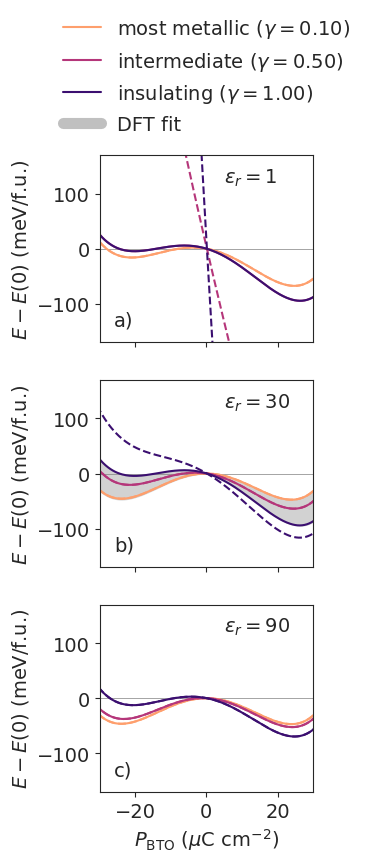

In [74]:
# thickness of slab
max_cell = 8
d = dvec[max_cell-1]

# array for p
c_bto = bto_polar.lattice.c
p_btos = np.linspace(-0.5, 0.5, nsamples)
p_snos = np.linspace(-0.49, 0.49, nsamples)
p_snos_tilted = np.linspace(-0.1, 0.1, nsamples)
i_uhp = p_btos < 0

# all eps_r
diff_epsr = np.array([1, 30, 90])

# different screening lengths
gamma = np.array([0.1, 0.5, 1])
lambda_res = gamma*d/2
print(f'lambdas: {lambda_res*1e10}')

# save double well potential for minimum sno polarization
energies_double_well_wscr = np.zeros([len(gamma)+1, len(p_btos)])
energies_double_well_nscr = np.zeros([len(gamma)+1, len(p_btos)])

# plot setup
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7*cm, 21*cm), sharex=True)
letter = ['a', 'b', 'c']
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'DejaVu Sans'


# loop different epsr
for e_i, epsr in enumerate(diff_epsr):
    # line at zero
    ax[e_i].axhline(0, color = 'gray', linestyle='-', linewidth = 0.5)

    # different screening lengts
    for k, f in enumerate(gamma):

        # results
        energies_hp_dep_wscr = np.zeros([len(p_btos), len(p_snos)])
        energies_hp_dep_nscr = np.zeros([len(p_btos), len(p_snos)])

        # loop over all possible polarizations and polar displacements
        for i, p_bto in enumerate(p_btos):
            for j, p_sno in enumerate(p_snos_tilted):

                energies_hp_dep_wscr[i,j], _, _ = energy_model_depol_and_selfscreen(p_bto, a_bto, b_bto, p_sno, a_sno, b_sno, dvec[max_cell-1], lambda_dep=None, e_g=eg, d_sno=d_vec_sno_wt[max_cell-1],   epsr=epsr, gamma=f)
                energies_hp_dep_nscr[i,j], _, _ = energy_model_depol_field(p_bto, a_bto, b_bto, p_sno, a_sno, b_sno, dvec[max_cell-1], lambda_dep=f*d/2, d_sno=d_vec_sno_wt[max_cell-1],   epsr=epsr)

        # minimum energy
        # happy orientation
        min_hp_wscr = getmin(energies_hp_dep_wscr)
        min_hp_nscr = getmin(energies_hp_dep_nscr)
        
        # unhappy orientatione
        min_uhp_wscr = getmin(energies_hp_dep_wscr[i_uhp])
        min_uhp_nscr = getmin(energies_hp_dep_nscr[i_uhp])

        # double well for p_sno = 0
        energies_double_well_wscr[k] = energies_hp_dep_wscr[:, i_middle]
        energies_double_well_nscr[k] = energies_hp_dep_nscr[:, i_middle]

        # energy difference between local minima double well
        print(f'epsr = {epsr}, gamma = {f}, happy: {(energies_hp_dep_wscr[min_hp_wscr[0], min_hp_wscr[1]]-energies_hp_dep_wscr[i_uhp][min_uhp_wscr[0], min_uhp_wscr[1]])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*max_cell)*1000:.2f} meV/f.u.')

    # for middle plot, aso calculate the limits obtained from the different screening lengths
    if e_i == 1:
        # limits to consider
        lambda_dep = 0.2*1e-10 # Thomas-Fermi screening length
        lambda_dep_fit = np.sqrt(1e-19*epsr) # fit to DFT data

        # array to store results
        energies_hp_dep_wscr = np.zeros([len(p_btos), len(p_snos)])
        energies_hp_dep_wscr_fit = np.zeros([len(p_btos), len(p_snos)])

        # loop over polarization and polar displacements
        for i, p_bto in enumerate(p_btos):
            for j, p_sno in enumerate(p_snos_tilted):

                energies_hp_dep_wscr[i,j], _, _ = energy_model_depol_and_selfscreen(p_bto, a_bto, b_bto, p_sno, a_sno, b_sno, dvec[max_cell-1], lambda_dep=lambda_dep, e_g=eg, d_sno=d_vec_sno_wt[max_cell-1],   epsr=epsr)
                energies_hp_dep_wscr_fit[i,j], _, _ = energy_model_depol_and_selfscreen(p_bto, a_bto, b_bto, p_sno, a_sno, b_sno, dvec[max_cell-1], lambda_dep=lambda_dep_fit, e_g=eg, d_sno=d_vec_sno_wt[max_cell-1],   epsr=epsr)


        # double well for p_sno = 0
        limit1 = energies_hp_dep_wscr[:, i_middle].copy()
        limit2 = energies_hp_dep_wscr_fit[:, i_middle].copy()

    # color
    colors = plt.cm.magma_r(np.linspace(0.2,0.8,len(lambda_res))) # get color map

    # label
    t = ax[e_i].text(5, 120, f'$\epsilon_r = ${epsr}')
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

    # add eps_r to plot
    t = ax[e_i].text(-26, -140, f'{letter[e_i]})')
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

    # legend
    line_wscr = mlines.Line2D([], [], color='black', linestyle='-', label='with $e^--h^+$')
    line_nscr = mlines.Line2D([], [], color='black', linestyle='--', label='no $e^--h^+$')
    line_sno = mlines.Line2D([], [], color='silver', linestyle='-', linewidth=8, label=r'DFT fit')
    line_small = mlines.Line2D([], [], color=colors[0], linestyle='-', label=f'most metallic ($\gamma = {gamma[0]:.2f}$)')
    line_middle = mlines.Line2D([], [], color=colors[1], linestyle='-', label=f'intermediate ($\gamma = {gamma[1]:.2f}$)')
    line_large = mlines.Line2D([], [], color=colors[2], linestyle='-', label=f'insulating ($\gamma = {gamma[2]:.2f}$)')


    # plot results for different screening lengths (different gamma)
    for i, l in enumerate(lambda_res):
        ax[e_i].plot(p_btos*100, (energies_double_well_wscr[i]-energies_double_well_wscr[i, i_middle])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*max_cell)*1000, label=f'{lambda_res[i]*10**10:.2f} A', color=colors[i])
        ax[e_i].plot(p_btos*100, (energies_double_well_nscr[i]-energies_double_well_nscr[i, i_middle])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*max_cell)*1000, '--', color=colors[i])

    
    # labels
    ax[e_i].set_ylabel('$E - E(0)$ (meV/f.u.)')
    ax[e_i].set_xlim(-30,30)
    ax[e_i].set_ylim(-170,170)

# add gray area for limiting screening lengths obtained from DFT 
ax[1].fill_between(p_btos*100, (limit1-limit1[i_middle])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*max_cell)*1000, (limit2-limit2[i_middle])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*max_cell)*1000, color='silver', alpha=0.7)

# x label
ax[-1].set_xlabel('$P_{\mathrm{BTO}}$ ($\mu$C cm$^{-2}$)')

# legend
ax[0].legend(handles=[line_small, line_middle, line_large, line_sno], loc = 'lower center', bbox_to_anchor = [0.5, 1.02],frameon=False)

# save
plt.savefig(f'{figures_out}fig10_compare_MIT_diff_epsr.pdf', bbox_inches='tight', transparent=True)

### Figure A1: Unhappy no rots

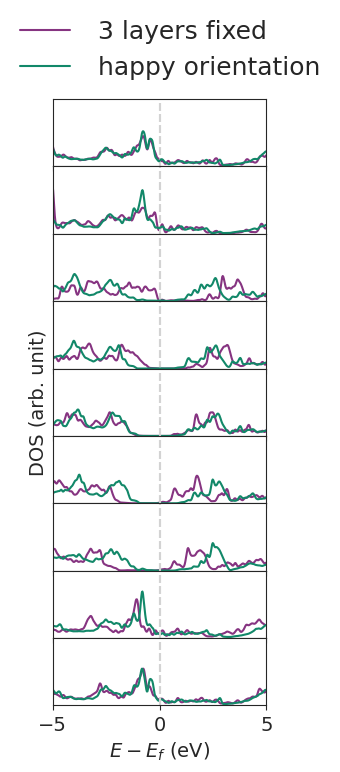

In [61]:
# plot parameters
fig, ax = plt.subplots(nrows = len(layer_5_nt_full), sharex = True, subplot_kw={'aspect': 'auto'})
plt.rcParams.update({'font.size': 18})
fig.subplots_adjust(hspace=0)
fig.set_size_inches([7*cm, 20*cm])

# plot
fig, ax = plot_dos_per_layer([fig,ax], [dos_uhp_nt], ['3 layers fixed'], layer_5bto_nt_uhp, sigma=0.05, colors=[colpal[3]])
fig, ax = plot_dos_per_layer([fig,ax], [dos_5_nt_full], ['happy orientation'], layer_5_nt_full, sigma=0.05, colors=[colpal[1]], ylim=[0,15])

# get legend
lgd = fig.legends[0]

# save
plt.savefig(f'{figures_out}figa1_dos_uhp_nt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)
plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4q/hrpky1793td3bsx9svzrq6p00000gq/T/ipykernel_69350/4279607966.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)")


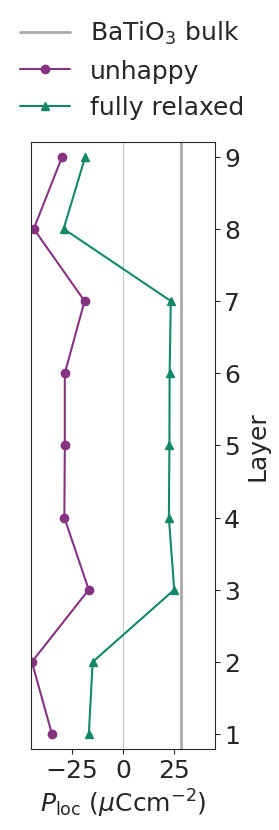

In [62]:
# plot parameters
fig, ax= plt.subplots(subplot_kw={'aspect': 'auto'})
fig.subplots_adjust(hspace=0)
fig.set_size_inches([6*cm, 20*cm])
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'DejaVu Sans'

# zero line
plt.axvline(0, color = 'darkgray', ls = '-', lw = 0.5)

# bulk polarization
plt.axvline(28.6, color = 'darkgray', ls = '-', lw = 2, label = 'BaTiO$_3$ bulk')

# polarization along c-axis
i_ax = 2
plt.plot(p_5bto_uh_nt_l3["pol."][:,i_ax],  np.arange(1, 10, 1), 'o-', label = 'unhappy', color = colpal[3])
plt.plot(p_full_happy["pol."][:,i_ax], np.arange(1, 10, 1), '^-',label = 'fully relaxed', color = colpal[1])

# labels and legend
lgd = plt.legend(loc = 'lower center', bbox_to_anchor = [0.55, 1.00], frameon=False, bbox_transform=ax.transAxes, fontsize=ax.xaxis.get_ticklabels()[0].get_fontsize())
plt.ylabel("Layer")
plt.xlabel("$P_\mathrm{loc}$ ($\mu$Ccm$^{-2}$)")

# move ticks and labels to the right
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# limits
plt.xlim([-45, 45])
plt.ylim([0.8, 9.2])

# save
plt.savefig(f'{figures_out}figa1_pol_uhp_nt.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight', transparent = True)
plt.show()

## Figure A3: Finding parameters for electrostatic model

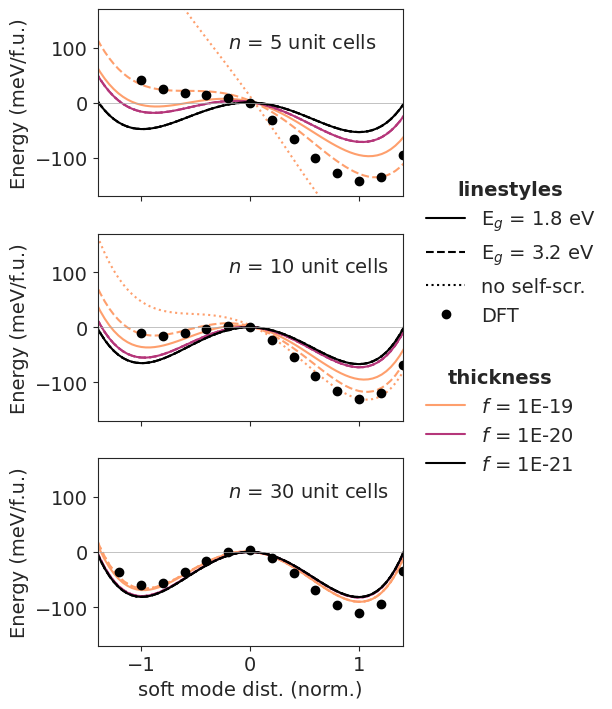

In [64]:

# plot parameters
fig, ax = plt.subplots(nrows = 3, figsize=(10*cm, 21*cm), sharex=True)
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'DejaVu Sans'

# colors for plot
colors = plt.cm.magma_r(np.linspace(0.2,0.8,3))
colors[-1] = [0, 0, 0, 1] # black

# number of batio3 unit cells
thickness = [4, 9, 29]


# --- Electrostatic model ---

# parameters to test in the electrostatic model
factor = np.array([1e-19, 1e-20, 1e-21])
epsr = 60 # sample relative permittivity
lambda_dep = np.sqrt(factor*epsr) # screening length for sample relative permittivity
egs = [1.8, 3.2] # band gap for BTO

# polarizations to test for electrostatic model
p_btos = np.linspace(-0.5, 0.5, 101)

# path to data
save_data_path = path_data+'/elstat_model/'

# load data from elstatic model
for i, f in enumerate(factor):
    energies_hp_dep = load_3d_array_from_txt(f'{save_data_path}4_uc_sno/energy_landscape_depANDsc_wt_factor={f:.2E}_eg={egs[0]}.txt')

    for j, a in enumerate(ax):
        energies_nt_i = energies_hp_dep[thickness[j],:,51]*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(4+c_vec[thickness[j]])*1000
        a.plot(p_btos/0.24, energies_nt_i-energies_nt_i[51], '-',  color=colors[i])

    # WITH SELS SCREENING
    energies_hp_dep = load_3d_array_from_txt(f'{save_data_path}4_uc_sno/energy_landscape_depANDsc_wt_factor={f:.2E}_eg={egs[1]}.txt')

    for j, a in enumerate(ax):
        energies_nt_i = energies_hp_dep[thickness[j],:,51]*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(4+c_vec[thickness[j]])*1000
        a.plot(p_btos/0.24, energies_nt_i-energies_nt_i[51], '--',  color=colors[i])

    # NO SELF SCREENING
    energies_hp_dep = load_3d_array_from_txt(f'{save_data_path}4_uc_sno/energy_nsc_landscape_wt_factor={f:.2E}_eg={eg}.txt')
    for j, a in enumerate(ax):
        energies_nt_i = energies_hp_dep[thickness[j],:,51]*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(4+c_vec[thickness[j]])*1000
        a.plot(p_btos/0.24, energies_nt_i-energies_nt_i[51], ':',  color=colors[i])


# --- DFT data ---

# fractional displacement of soft mode in BTO DFT
frac_displ_res = np.linspace(-1.2, 1.4, 14)

# convert dft data to meV/f.u.
e_dft_30 = 1000*(en_frac_nt_nr_30-en_frac_nt_nr_30[5])/((4+30))
e_dft_10 = 1000*(en_frac_nt_nr[1]-en_frac_nt_nr[1,5])/((4+10))
e_dft_5 = 1000*(en_frac_nt_nr[0]-en_frac_nt_nr[0,5])/((4+5))

# plot DFT data
ax[0].plot(frac_displ_res_5, e_dft_5, 'o', label='DFT', color='black')
ax[1].plot(frac_displ_res_5, e_dft_10, 'o', label='DFT', color='black')
ax[2].plot(frac_displ_res, e_dft_30, 'o', label='DFT', color='black')

# --- plot setup ---

# lines for legend: linestiles
line_34 = mlines.Line2D([], [], color='black', linestyle='--', label='E$_g$ = 3.2 eV')
line_18 = mlines.Line2D([], [], color='black', linestyle='-', label='E$_g$ = 1.8 eV')
line_nsc = mlines.Line2D([], [], color='black', linestyle=':', label='no self-scr.')
line_dft = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='DFT')

# lines for legend: thickness
thickness_lines = [mlines.Line2D([], [], color=colors[i], label=f'$f$ = {factor[i]:.0E}') for i, f in enumerate(factor)]

# label and limits for all plots
for i, a in enumerate(ax):
    a.set_ylabel('Energy (meV/f.u.)')
    a.set_xlim(-1.4, 1.4)
    a.set_ylim(-170, 170)
    a.axhline(0, color='darkgray', ls='-', lw=0.5)
    t = a.text(-0.2, 100, f'$n$ = {thickness[i]+1} unit cells')
    t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

# x label to last plot
ax[-1].set_xlabel('soft mode dist. (norm.)')

# plot legend
ax[1].legend(handles=[line_18, line_34, line_nsc, line_dft],loc = 'center left', bbox_to_anchor = [1.02, 0.9], frameon=False, title='linestyles',  title_fontproperties={'weight':'bold'})
ax[2].legend(handles=thickness_lines,loc = 'center left', bbox_to_anchor = [1.02, 1.2], frameon=False, title='thickness',  title_fontproperties={'weight':'bold'})

# save
fig.savefig(f'{figures_out}figa2_find_best_params.pdf', bbox_inches='tight')
plt.show()

## Figure A3: Difference energy of happy and unhappy orientation in electrostatic model

Delta E with rotations, slab thickness = 30 u.c.: 8.5 meV/f.u. or thickness 100 u.c.: 1.0527439985031426 meV/f.u.
Delta E without rotations, slab thickness = 30 u.c.: 6.2 meV/f.u. or thickness 100 u.c.: 0.8855175316436803 meV/f.u.
Delta E > 10meV/f.u.: with rotations for less than 9, and without rotations for less than 9
Delta E > 50meV/f.u.: with rotations for less than 9, and without rotations for less than 9


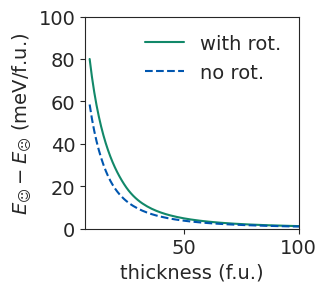

In [68]:
# parameters for electrostatic model
factor = 1e-19
eg = 3.2
c_vec = np.arange(1, 201, 1)

# read in data
save_data_path = path_data+'/elstat_model/'
results_hp_dep_wt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_hp_dep_wt_factor={factor:.2E}_eg={eg}.txt') # happy orientation with rotation
results_hp_dep_nt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_hp_dep_nt_factor={factor:.2E}_eg={eg}.txt') # happy orientation without rotation
results_uhp_dep_wt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_uhp_dep_wt_factor={factor:.2E}_eg={eg}.txt') # unhappy orientation with rotation
results_uhp_dep_nt = np.loadtxt(f'{save_data_path}opt_results_depANDsc_uhp_dep_nt_factor={factor:.2E}_eg={eg}.txt') # unhappy orientation without rotation

# plot parameters
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'DejaVu Sans'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7*cm, 7*cm), sharex=True)

# calculate energy difference in meV/f.u.
ediff_wt = (results_uhp_dep_wt[8:,2]-results_hp_dep_wt[8:,2])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*c_vec[8:])*1000
ediff_nt = (results_uhp_dep_nt[8:,2]-results_hp_dep_nt[8:,2])*bto_polar.lattice.a*bto_polar.lattice.b*1e-20/(2*c_vec[8:])*1000
ax.plot(c_vec[8:], ediff_wt, '-', label='with rot.', color = colpal[1])
ax.plot(c_vec[8:], ediff_nt, '--', label='no rot.', color = colpal[2])

# print energy difference at thickness 30 and 100 u.c.
print(f'Delta E with rotations, slab thickness = 30 u.c.: {ediff_wt[29]:.1f} meV/f.u. or thickness 100 u.c.: {ediff_wt[99]} meV/f.u.')
print(f'Delta E without rotations, slab thickness = 30 u.c.: {ediff_nt[29]:.1f} meV/f.u. or thickness 100 u.c.: {ediff_nt[99]} meV/f.u.')

# print thickness when energy difference is less than 10 and 50 meV/f.u.
print(f'Delta E > 10meV/f.u.: with rotations for less than {c_vec[8:][ediff_wt>-10][0]}, and without rotations for less than {c_vec[8:][ediff_nt>-10][0]}')
print(f'Delta E > 50meV/f.u.: with rotations for less than {c_vec[8:][ediff_wt>-50][0]}, and without rotations for less than {c_vec[8:][ediff_nt>-50][0]}')

# legend, labels and limits
plt.xlabel('thickness (f.u.)')
plt.xlim(7, 100)
plt.ylim(0, 100)
plt.legend(frameon=False)
plt.ylabel('$E_{\U0000263A}-E_{\U00002639}$ (meV/f.u.)')

# save figure
plt.savefig(f'{figures_out}figa3_e_diff_wt_nt.pdf', bbox_inches='tight', transparent=True)

## APPENDIX C: TF-screening length

Thomas-Fermi screening lengths

In [21]:
# read in vasp output for bulk smnio3 with and without rotations
vaspout_nt = Vasprun(path_data+'/bulk/smnio3/no_rots/222_dos/dos/vasprun.xml')
vaspout_wt = Vasprun(path_data+'/bulk/smnio3/with_rots/dos/vasprun.xml')


# get volume
struct = Structure.from_file(path_data+'/bulk/smnio3/no_rots/222_dos/dos/POSCAR')
vol_nt = struct.volume # no rotations

struct = Structure.from_file(path_data+'/bulk/smnio3/with_rots/dos/POSCAR')
vol_wt = struct.volume # with rotations

# get DOS
dos_dict_nt = vaspout_nt.complete_dos.as_dict()
dos_dict_wt = vaspout_wt.complete_dos.as_dict()

# constants
ev2j = 1.602176634*1e-19 # conversion factor from eV to J
e = 1.6e-19  # The electronic charge in C
a0 = 5.29*10**(-11)  # The Bohr radius in m
eps_0 = 8.85*10**(-12)  # The vacuum permittivity in F/m

# loop over different relative permittivities
for eps_r in [1,6]:
    print(f'eps_r = {eps_r}')
    print('---')

    # no rotations
    min_i = np.argmin(np.abs(np.array(dos_dict_nt['energies'])-dos_dict_nt['efermi'])) # find index of E_f
    dos_efermi_nt = dos_dict_nt['densities']['1'][min_i] / ev2j # convert DOS @ E_f to state/J
    dos_efermi_nt /= (vol_nt*10**(-30)) # convert to state/A^3
    print(f'DOS @ E_f, no rots: {dos_efermi_nt*1e-30:.2E} states/A^3')

    # with rotatopmss
    min_i = np.argmin(np.abs(np.array(dos_dict_wt['energies'])-dos_dict_wt['efermi']))
    dos_efermi_wt = dos_dict_wt['densities']['1'][min_i] / ev2j
    dos_efermi_wt /= (vol_wt*10**(-30))
    print(f'DOS @ E_f, with rots: {dos_efermi_wt*1e-30:.2E} states/A^3')


    # estimate screening length
    len_nt = (e**2 * dos_efermi_nt/eps_0/eps_r)**(-1/2)
    print(f'screening length, no rots: {len_nt*10**10:.3f} A')

    len_wt = (e**2 * dos_efermi_wt/eps_0/eps_r)**(-1/2)
    print(f'screening length, with rots: {len_wt*10**10:.3f} A')

eps_r = 1
---
DOS @ E_f, no rots: 1.43E+17 states/A^3
DOS @ E_f, with rots: 2.06E+17 states/A^3
screening length, no rots: 0.491 A
screening length, with rots: 0.409 A
eps_r = 6
---
DOS @ E_f, no rots: 1.43E+17 states/A^3
DOS @ E_f, with rots: 2.06E+17 states/A^3
screening length, no rots: 1.203 A
screening length, with rots: 1.003 A


Screening length from electric field in core states of the DOS

In [52]:

# limits for core states in DOS
e_min = -29
e_max = -24

# constants
e = 1.6e-19 # The electronic charge in C
eps_0 = 8.85*10**-12 # vacuum permittivity in C/V/m

# epsilons to loop over
eps_rs = [1, 6]

# arrays to store results
nlayers = len(layer_5bto_uhp[0])
av_lambda_epsr = np.zeros(len(eps_rs))
lambdas_nt = np.zeros(len(eps_rs))
lambdas_wt = np.zeros(len(eps_rs))

# loop over different relative permittivities
for i_eps, eps_r in enumerate(eps_rs):

    j = 0 # counter for batio3 layers

    # array to store max values
    max_vals_nt = np.zeros(5)
    max_vals_wt = np.zeros(5)

    # loop over all layers
    for i in range(nlayers):
        if i <2 or i > 6: # skip smnio3 layers
            continue

        # no rots
        dos_layer_i = get_summed_dos_for_layer(dos_5_nt, layer_5_nt[i], sigma=0.03) # get DOS for layer i
        energies = np.array(dos_5_nt['energies'])-dos_5_nt['efermi'] # energy w.r. to E_f
        indices = np.logical_and((energies>e_min), (energies<e_max)) # indices in interval
        max_vals_nt[j] = energies[indices][np.argmax(dos_layer_i[indices])] # get max value in interval

        # with rots
        dos_layer_i = get_summed_dos_for_layer(dos_bto5_nr, layer_5_bto_nr[i], sigma=0.03)
        energies = np.array(dos_bto5_nr['energies'])-dos_bto5_nr['efermi']
        indices = np.logical_and((energies>e_min), (energies<e_max))
        max_vals_wt[j] = energies[indices][np.argmax(dos_layer_i[indices])]
        
        j += 1


    # energy difference between first and lest element of unrelaxed structures
    diff_nt = max_vals_nt[0]-max_vals_nt[-1]
    diff_wt = max_vals_wt[0]-max_vals_wt[-1]


    # convert energy to voltages
    diff_nt_v = diff_nt 
    diff_wt_v = diff_wt 

    # screening length from voltage difference
    lambda_nt = diff_nt_v*eps_0*eps_r/(0.5)/2
    lambda_wt = diff_wt_v*eps_0*eps_r/(0.5)/2

    # append screening length in Angstrom
    lambdas_nt[i_eps] = lambda_nt*10**10
    lambdas_wt[i_eps] = lambda_wt*10**10

    # average screening length
    av_lambda_epsr[i_eps] = (lambdas_nt[i_eps] + lambdas_wt[i_eps])/2


# print results
print('average screening lengths for', ''.join([f'eps_r = {eps_rs[i_eps]}: {av_lambda_epsr[i_eps]:.1f} A, ' for i_eps in range(len(eps_rs))]))

average screening lengths for eps_r = 1: -0.2 A, eps_r = 6: -1.1 A, 


## Figure A4: Electronic screening length SNO

In [53]:
def return_max_val(dos_layer_i, dos_dict, xlims):
    energies = np.array(dos_dict['energies'])-dos_dict['efermi']
    energy_range = np.logical_and((energies>xlims[1]), (energies<xlims[0]))
    # print(energy_range)
    return energies[energy_range][np.argmax(dos_layer_i[energy_range])]

In [56]:
# GET ONLY SNO LAYERS DOS
xlims = np.array([-39,-42]) # limits for core state energies of smnio3
nlayers = len(layer_8sno_nt_nr) # number of layers in the system

# arrays to store results
dos_8_nr = [] # DOS for 8 layers
max_vals_8sno_nr = [] # max values of core states peaks for 8 layers

dos_6_nr = []
max_vals_6sno_nr = []

dos_4_nr = []
max_vals_4sno_nr = []

for i in range(nlayers):
    
    if i < 2 or i > 6:
    #WITH rots
        dos_8_nr.append(get_summed_dos_for_layer(dos_8sno_nt_nr, layer_8sno_nt_nr[i], sigma=0.05))
        max_vals_8sno_nr.append(return_max_val(dos_8_nr[-1], dos_8sno_nt_nr, xlims))

    
        if i < 11:
            # print(ind_6)
            dos_6_nr.append(get_summed_dos_for_layer(dos_6sno_nt_nr, layer_6sno_nt_nr[i], sigma=0.05))
            max_vals_6sno_nr.append(return_max_val(dos_6_nr[-1], dos_6sno_nt_nr, xlims))
            
        if i < 9:
            dos_4_nr.append(get_summed_dos_for_layer(dos_5_nt, layer_5_nt[i], sigma=0.05))
            max_vals_4sno_nr.append(return_max_val(dos_4_nr[-1], dos_5_nt, xlims))

In [57]:
# Rearrange SmNiO3 layers: move two bottom layers of smnio3 to the top
inds = np.arange(0,8,1)
temp = inds[2:].copy()
inds[-2:] = inds[0:2]
inds[0:-2] = temp
print(inds)

inds_6 = np.arange(0,6,1)
temp = inds_6[2:].copy()
inds_6[-2:] = inds_6[0:2]
inds_6[0:-2] = temp
print(inds_6)

inds_4= np.arange(0,4,1)
temp = inds_4[2:].copy()
inds_4[-2:] = inds_4[0:2]
inds_4[0:-2] = temp
print(inds_4)

[2 3 4 5 6 7 0 1]
[2 3 4 5 0 1]
[2 3 0 1]


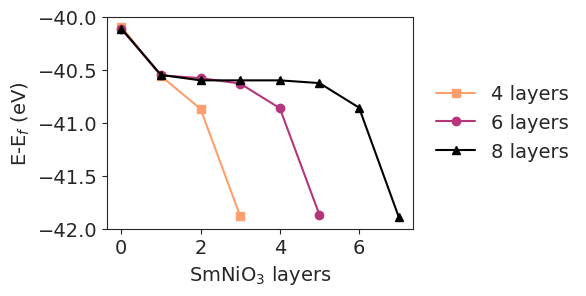

In [60]:
# plot setup
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'DejaVu Sans'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10*cm, 7*cm), sharex=True)

# plot results
plt.plot(np.array(max_vals_4sno_nr)[inds_4], '-s', label =   '4 layers', color = colors[0])
plt.plot(np.array(max_vals_6sno_nr)[inds_6], '-o',  label =  '6 layers', color = colors[1])
plt.plot(np.array(max_vals_8sno_nr)[inds], '-^',  label =   '8 layers', color = 'black')

# plot legend
plt.legend(bbox_to_anchor = [1.02, 0.5], frameon=False, loc = 'center left')

# labels and limits
plt.xlabel('SmNiO$_3$ layers')
plt.ylim([-42, -40])
plt.ylabel('E-E$_f$ (eV)')

# save
plt.savefig(f'{figures_out}figa4_corestates_sno.pdf', bbox_inches='tight', transparent=True)